# **Modeling Madrid House Prices with Linear Regression**

## **Requirements**

In [1]:
import polars as pl
import pandas as pd
import numpy as np
#import sys
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from IPython.display import Image
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import ast
from math import factorial
import itertools
from itertools import combinations
from sklearn.model_selection import KFold
import scipy

In [2]:
#sys.path.insert(0, 'C:/Users/fscielzo/Documents/DataScience-GitHub/EDA')
from EDA import dtypes_df, count_col_nulls, corr_matrix, outliers_table,  scatter_matrix, boxplot_2D_matrix, histogram_2D_matrix, ecdf_2D_matrix, quant_to_cat
from EDA import  histogram, freq_table, outlier_filter, summary, boxplot, ecdfplot, stripplot_matrix, transform_to_dummies, cross_quant_cat_summary

## **Conceptual description of the data**

The data set of this project  contains information about Madrid houses extracted from Real State web portals.

The data has been obtained from `Kaggle`:  https://www.kaggle.com/datasets/makofe/housesclean

The following table summarize conceptually the variables contained in the data set with which we will work along this project.

| Variable Name | Description | Type |
|----------|----------|----------|
| `sq_mt_built`    |  size of the house in square meter built   |   Quantitative  |
| `n_rooms`    | Number of rooms of the house     | Quantitative  |
| `n_bathrooms`   |  Number of bathrooms of the house     |  Quantitative  |
| `n_floors`   | Number of floors of the house   |  Quantitative  |
| `sq_mt_allotment`   |   for detached houses, full size including house, pool, garden, etc   |  Quantitative  |
| `floor`   |  Indicates the house height   |  Multiclass  |
| `is_renewal_needed`   |  Indicates wether the house needs renewal or not    |  Binary  |
| `has_lift`   |  Indicates wether the house has lift or not     |  Binary  |
| `is_exterior`   |  Indicates wether the house is exterior or not    |  Binary  |
| `energy_certificate`   |  higher values mean more efficient energy system   |  Multiclass  |
| `has_parking`   |  Indicates wether the house has parking or not   |  Binary  |
| `neighborhood`   |  Madrid's neighborhoods  |  Multiclass  |
| `district`   |  Madrid's districts  |  Multiclass  |
| `house_type`   |  Indicates the house type: flat (0), chalet (1), study (2), duplex (3), top floor (4)  |  Multiclass  |
| `buy_price`   |  The buy price of the house    |  Quantitative  |

## **Reading the data**

First of all, we read the data.

In [3]:
madrid_houses_df = pl.read_csv('madrid_houses.csv')

In [4]:
madrid_houses_df.head()

,id,sq_mt_built,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,floor,buy_price,is_renewal_needed,has_lift,is_exterior,energy_certificate,has_parking,neighborhood,district,house_type
i64,i64,f64,i64,i64,i64,f64,i64,i64,bool,bool,bool,i64,bool,i64,i64,i64
0,21742,64.0,2,1,1,0.0,3,85000,false,false,true,4,false,135,21,1
1,21741,70.0,3,1,1,0.0,4,129900,true,true,true,0,false,132,21,1
2,21740,94.0,2,2,1,0.0,1,144247,false,true,true,0,false,134,21,1
3,21739,64.0,2,1,1,0.0,-1,109900,false,true,true,0,false,134,21,1
4,21738,108.0,2,2,1,0.0,4,260000,false,true,true,0,true,133,21,1


In [5]:
madrid_houses_df.shape

(21739, 17)

## **Data preprocessing**

In this section we are going to carry out some preprocessing tasks on the data.

### **Removing some variables**

We will remove some variables that will be not used in the project.

In [6]:
variables_to_remove = ['', 'id', 'district', 'neighborhood']
variables_to_keep = [x for x in madrid_houses_df.columns if x not in variables_to_remove]

In [7]:
madrid_houses_df = madrid_houses_df[variables_to_keep]
madrid_houses_df.head()

sq_mt_built,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,floor,buy_price,is_renewal_needed,has_lift,is_exterior,energy_certificate,has_parking,house_type
f64,i64,i64,i64,f64,i64,i64,bool,bool,bool,i64,bool,i64
64.0,2,1,1,0.0,3,85000,false,false,true,4,false,1
70.0,3,1,1,0.0,4,129900,true,true,true,0,false,1
94.0,2,2,1,0.0,1,144247,false,true,true,0,false,1
64.0,2,1,1,0.0,-1,109900,false,true,true,0,false,1
108.0,2,2,1,0.0,4,260000,false,true,true,0,true,1


### **Data types**

We check the variables data types according to `polars` structure.

In [8]:
dtypes_df(df=madrid_houses_df)

Columns,Python_type
str,object
"""sq_mt_built""",Float64
"""n_rooms""",Int64
"""n_bathrooms""",Int64
"""n_floors""",Int64
"""sq_mt_allotmen…",Float64
"""floor""",Int64
"""buy_price""",Int64
"""is_renewal_nee…",Boolean
"""has_lift""",Boolean


### **Unique values**

We compute the unique values of each variable, what is useful to get a more real idea of their nature.

In [9]:
for col in madrid_houses_df.columns :
    display(madrid_houses_df[col].unique())

sq_mt_built
f64
13.0
15.0
16.0
18.0
19.0
20.0
21.0
22.0
23.0


n_rooms
i64
0
1
2
3
4
5
6
7
8


n_bathrooms
i64
1
2
3
4
5
6
7
8
9


n_floors
i64
1
2
3
4
5
7


sq_mt_allotment
f64
0.0
10.0
20.0
22.0
25.0
27.0
28.0
29.0
30.0


floor
i64
-5
-3
-2
-1
0
1
2
3
4


buy_price
i64
36000
39000
42000
49000
49500
52000
52990
53000
54000


is_renewal_needed
bool
false
true


has_lift
bool
false
true


is_exterior
bool
true
false


energy_certificate
i64
0
1
2
3
4
5
6
7


has_parking
bool
false
true


house_type
i64
1
2
3
4
5


### **Standard encoding**

We will apply standard encoding on the categorical variables.

The variables to apply standard encoding are the following:

In [10]:
cols_to_std_encoding = ['house_type', 'has_parking', 'is_exterior', 'is_renewal_needed', 'has_lift']

In [11]:
for col in cols_to_std_encoding :

    X_std_encoding = OrdinalEncoder(dtype=int).fit_transform(madrid_houses_df[[col]]).flatten()
    madrid_houses_df = madrid_houses_df.with_columns(pl.Series(X_std_encoding).alias(col))

In [12]:
madrid_houses_df.head()

sq_mt_built,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,floor,buy_price,is_renewal_needed,has_lift,is_exterior,energy_certificate,has_parking,house_type
f64,i64,i64,i64,f64,i64,i64,i32,i32,i32,i64,i32,i32
64.0,2,1,1,0.0,3,85000,0,0,1,4,0,0
70.0,3,1,1,0.0,4,129900,1,1,1,0,0,0
94.0,2,2,1,0.0,1,144247,0,1,1,0,0,0
64.0,2,1,1,0.0,-1,109900,0,1,1,0,0,0
108.0,2,2,1,0.0,4,260000,0,1,1,0,1,0


### **Missing values**

We check if there are missing values (null/NaN) in our data.

In [13]:
count_col_nulls(madrid_houses_df)

sq_mt_built,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,floor,buy_price,is_renewal_needed,has_lift,is_exterior,energy_certificate,has_parking,house_type
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0


There are non missing values in this case.

## **Train-Test Split**

We perform a train-test split. Along the most part of the project we will only use the train part, since it plays the role of the data that we have in reality, and the test partition only should be used to estimate the predictive performance of the model with "new" data (estimation of future performance).

In [14]:
response = 'buy_price'
predictors = [x for x in madrid_houses_df.columns if x != response]

In [15]:
X = madrid_houses_df[predictors]
Y = madrid_houses_df[response]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.70, random_state=123)
X_Y_train_df = pl.concat((X_train, pl.DataFrame(Y_train)), how='horizontal')
X_Y_test_df = pl.concat((X_test, pl.DataFrame(Y_test)), how='horizontal')

## **EDA**

In this section we are going to complement this predictive modeling project with  an exploratory data analysis.

We are going to carry out an exploratory data analysis (EDA) only on training data because of the above. 

### **Descriptive summary**

In [16]:
quant_columns = ['sq_mt_built', 'n_rooms', 'n_bathrooms', 'n_floors', 'sq_mt_allotment', 'buy_price']
cat_columns = [x for x in madrid_houses_df.columns if x not in quant_columns]

In [17]:
quant_summary, cat_summary = summary(df=X_Y_train_df, auto_col=False,
                                     quant_col_names=quant_columns,
                                     cat_col_names=cat_columns)

In [18]:
quant_summary

,sq_mt_built,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,buy_price
n_unique,689,17,15,6,304,2034
prop_nan,0.0,0.0,0.0,0.0,0.0,0.0
mean,154.019155,3.012683,2.098311,1.235263,59.190708,651756.495038
std,164.515279,1.509707,1.407854,0.710341,398.791114,776142.000602
min,13.0,0.0,1.0,1.0,0.0,39000.0
Q10,55.0,1.0,1.0,1.0,0.0,135500.0
Q25,70.0,2.0,1.0,1.0,0.0,199000.0
median,100.0,3.0,2.0,1.0,0.0,375000.0
Q75,165.0,4.0,2.0,1.0,0.0,755000.0
Q90,314.0,5.0,4.0,2.0,0.0,1550000.0


In [19]:
cat_summary

,floor,is_renewal_needed,has_lift,is_exterior,energy_certificate,has_parking,house_type
n_unique,15,2,2,2,8,2,5
prop_nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mode,1,0,1,1,0,0,0


### **Outliers**

In [20]:
outliers_table(df=X_Y_train_df, auto=False, col_names=quant_columns)

quant_variables,lower_bound,upper_bound,n_outliers,n_not_outliers,prop_outliers,prop_not_outliers
str,f64,f64,i64,i64,f64,f64
"""sq_mt_built""",-72.5,307.5,1574,13643,0.103437,0.896563
"""n_rooms""",-1.0,7.0,151,15066,0.009923,0.990077
"""n_bathrooms""",-0.5,3.5,1964,13253,0.129066,0.870934
"""n_floors""",1.0,1.0,1811,13406,0.119012,0.880988
"""sq_mt_allotmen…",0.0,0.0,1003,14214,0.065913,0.934087
"""buy_price""",-635000.0,1.589e6,1487,13730,0.09772,0.90228


In [21]:
X_Y_train_df_trimmed = X_Y_train_df
for col in quant_columns:
    X_Y_train_df_trimmed = outlier_filter(X_Y_train_df_trimmed, col=col, h=1.5)

### **Response analysis**

#### **Histogram**

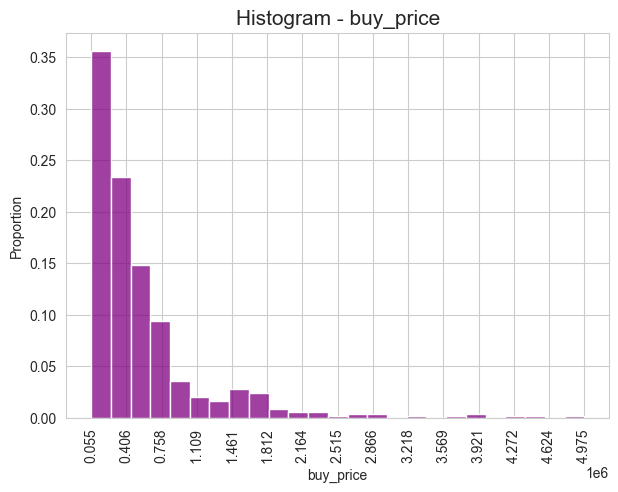

In [22]:
histogram(X=X_Y_train_df[response], bins=25, color='purple', figsize=(7,5), random=True, n=500, seed=123, x_rotation=90) 

#### **Frequencies**

In [23]:
response_cat = quant_to_cat(X_Y_train_df[response], rule='quartiles', n_intervals=4, random_seed=123)

In [25]:
freq_table(X=response_cat)


buy_price: unique values,abs_freq,rel_freq,cum_abs_freq,cum_rel_freq
object,i64,f64,i64,f64
"(-inf, 39000]",1,0.0001,1,0.000066
"(39000, 199000]",3829,0.2516,3830,0.251692
"(199000, 375000]",3827,0.2515,7657,0.503187
"(375000, 755000]",3756,0.2468,11413,0.750016
"(755000, 8800000]",3804,0.25,15217,1.0


#### **Boxplot**

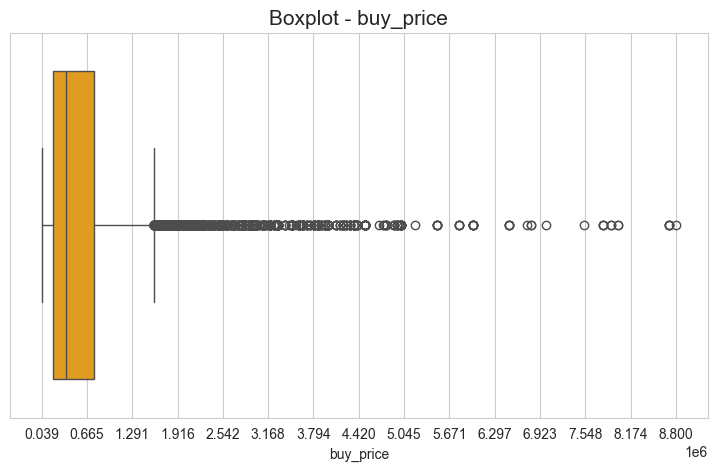

In [59]:
boxplot(X=X_Y_train_df[response], color='orange', figsize=(9,5), n_xticks=15, x_rotation=0, statistics=False)

#### **ECDF-plot**

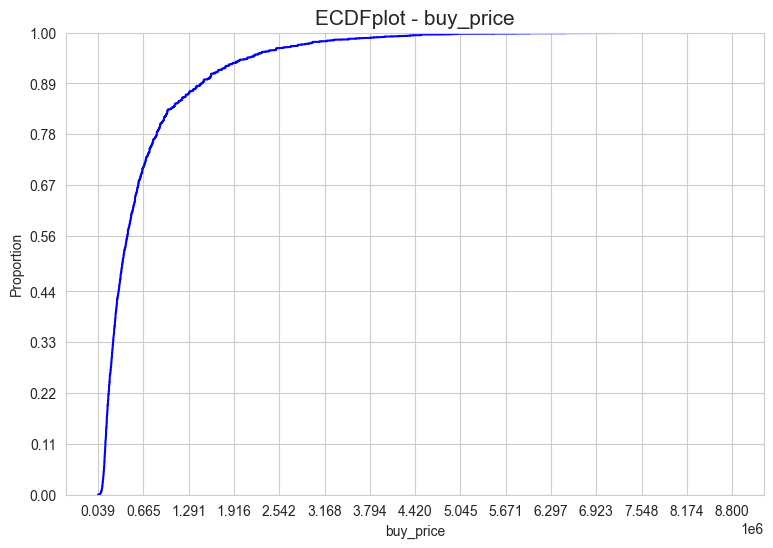

In [60]:
ecdfplot(X=X_Y_train_df[response], color='blue', figsize=(9,6))

### **Relation between response and predictors**

In [61]:
quant_predictors = [x for x in quant_columns if x != response]
cat_predictors = [x for x in cat_columns if x != response]

In [62]:
corr_matrix_response = corr_matrix(df=X_Y_train_df, response=response, predictors=quant_predictors, method='pearson')

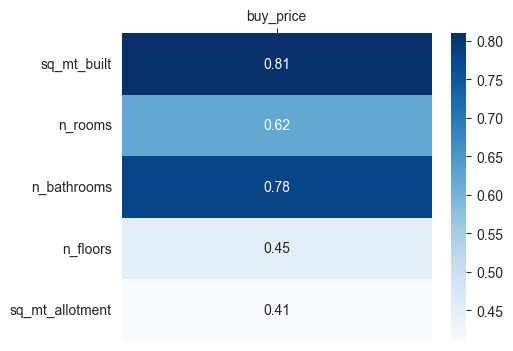

In [63]:
fig = plt.subplots(figsize=(5,4))
ax = sns.heatmap(corr_matrix_response, cmap="Blues", annot=True)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.show()

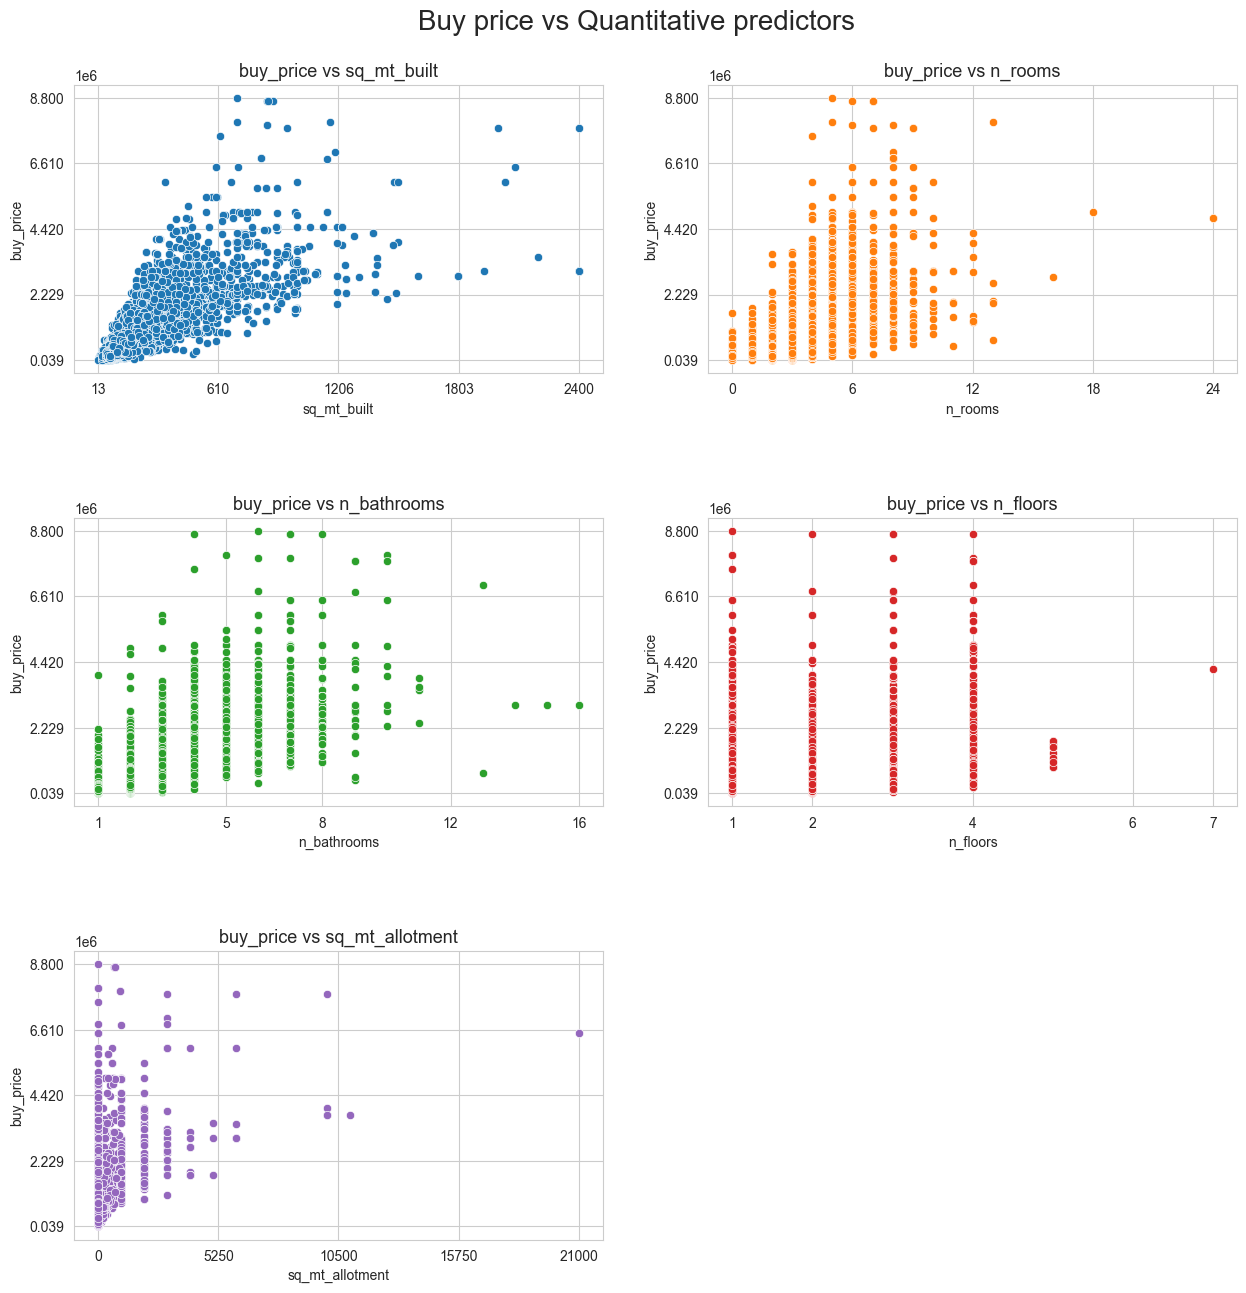

In [64]:
scatter_matrix(df=X_Y_train_df, n_cols=2, tittle='Buy price vs Quantitative predictors', 
               figsize=(15,15), response=[response], predictors=quant_predictors,
               n_yticks=5, n_xticks=5, title_height=0.93, hspace=0.5, fontsize=20)

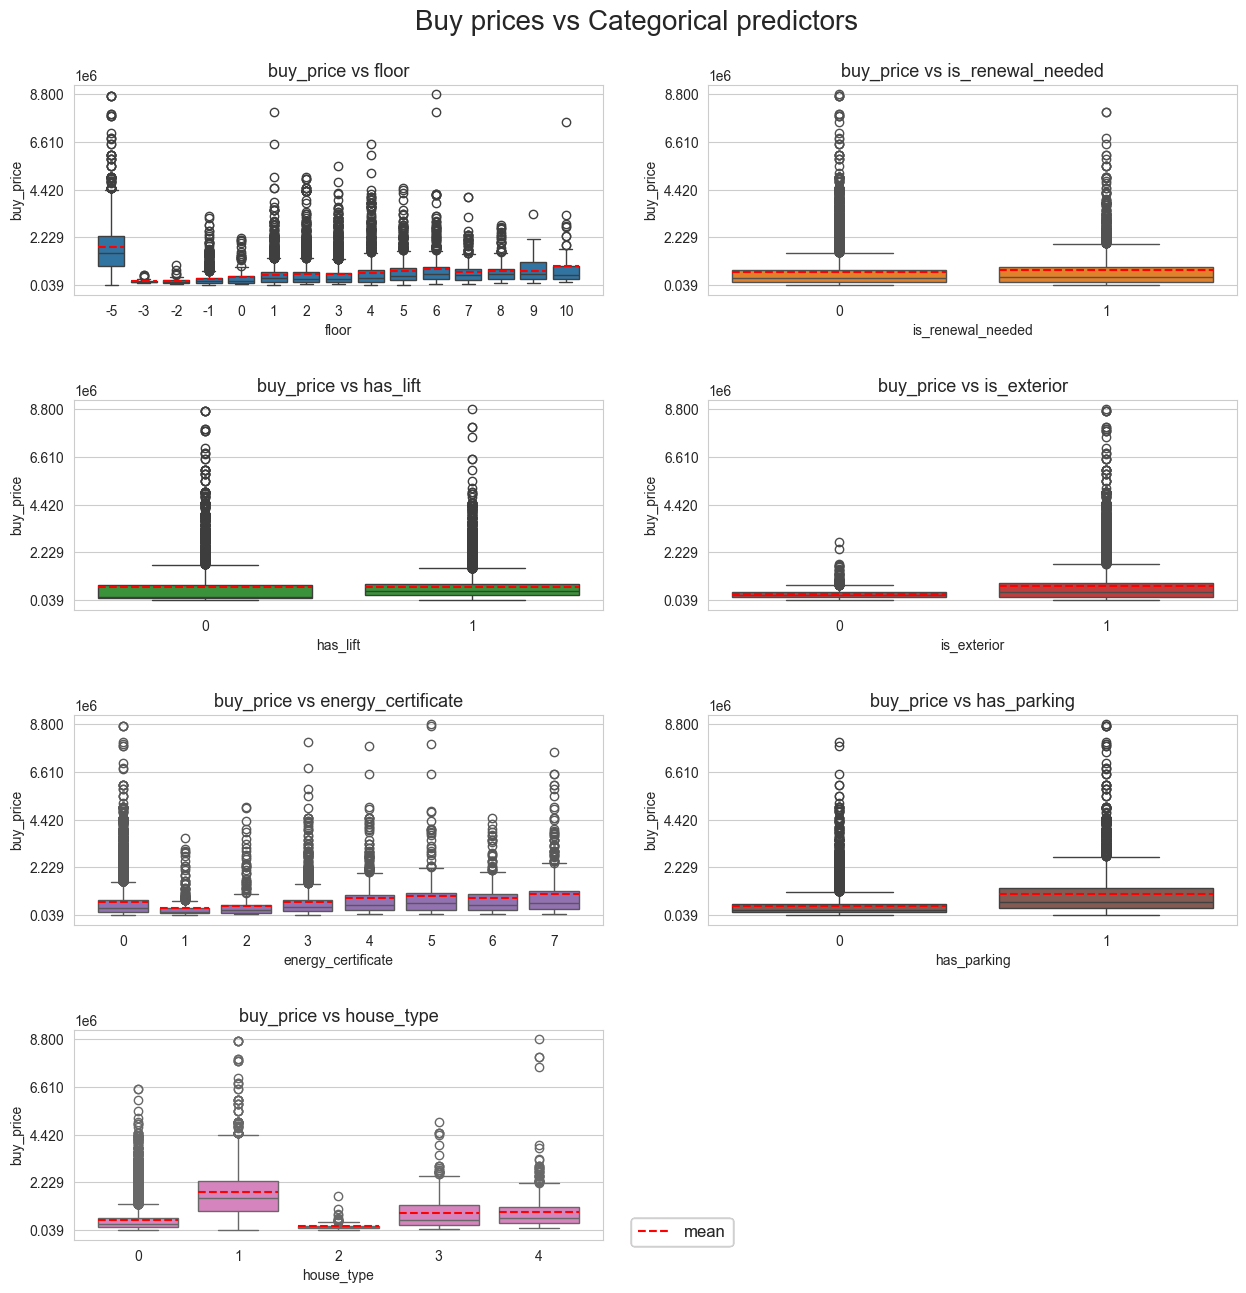

In [65]:
boxplot_2D_matrix(df=X_Y_train_df, n_cols=2, tittle='Buy prices vs Categorical predictors', figsize=(15,15), 
                 response=[response], predictors=cat_predictors,
                 n_yticks=5, title_height=0.93, hspace=0.5, fontsize=20,
                 statistics=['mean'], lines_width=0.8, bbox_to_anchor=(0.53,0.1), 
                 legend_size=12, color_stats=['red'], showfliers=True)

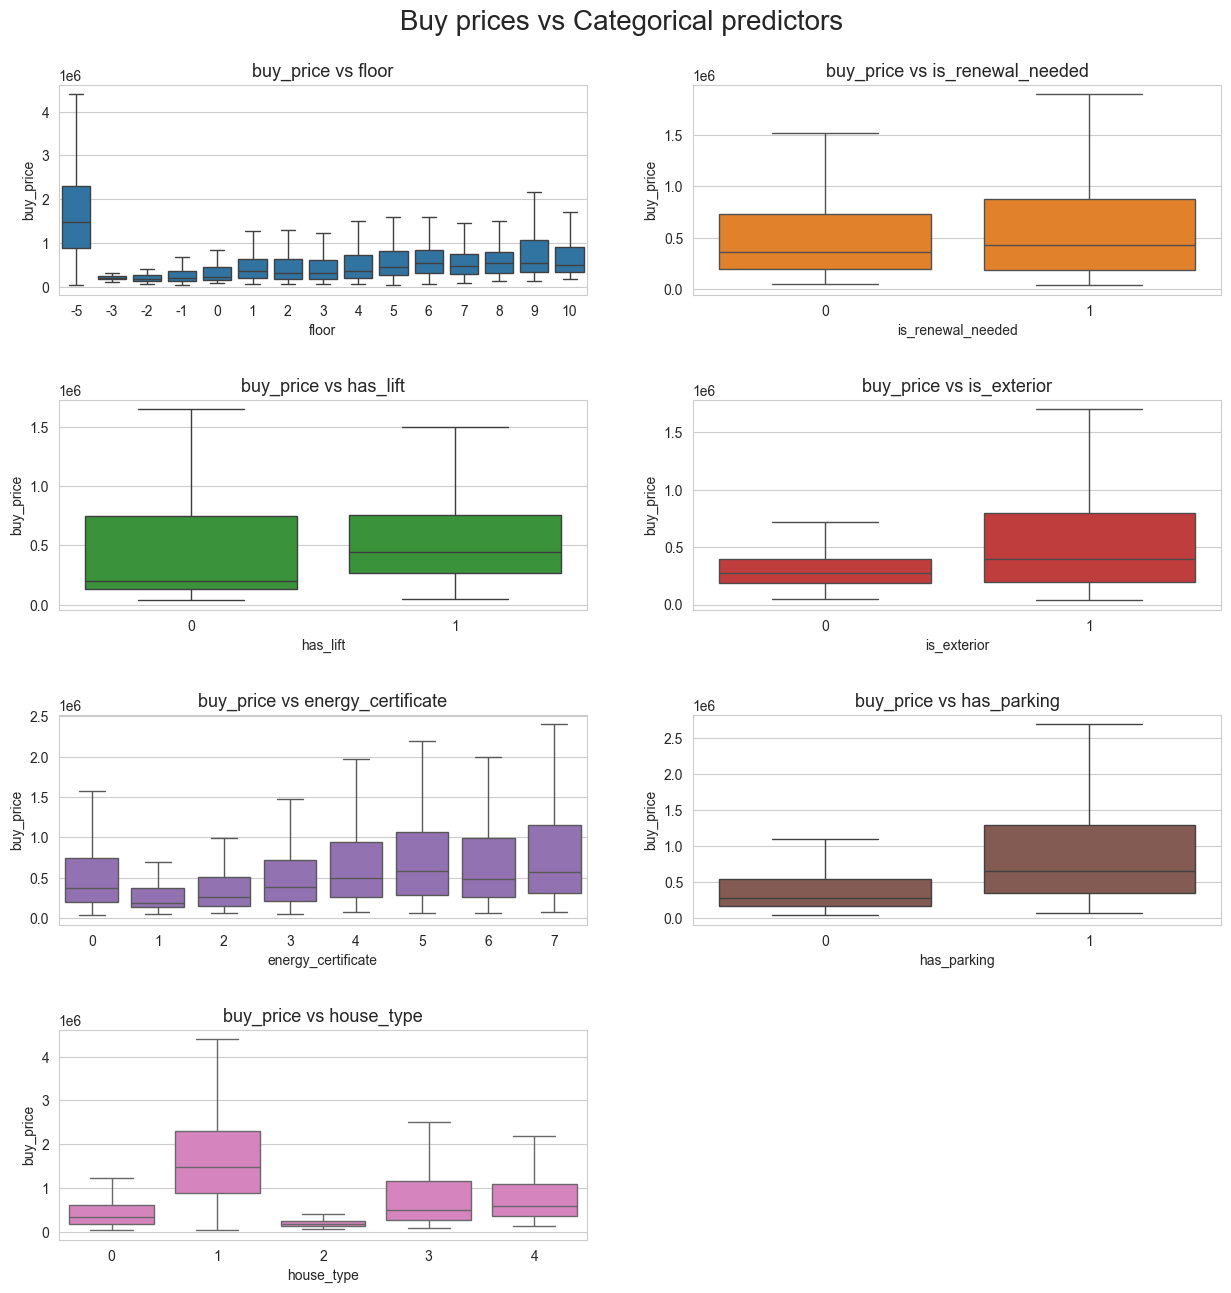

In [66]:
boxplot_2D_matrix(df=X_Y_train_df, n_cols=2, tittle='Buy prices vs Categorical predictors', figsize=(15,15), 
                 response=[response], predictors=cat_predictors,
                 n_yticks=5, title_height=0.93, hspace=0.5, fontsize=20,
                 showfliers=False)

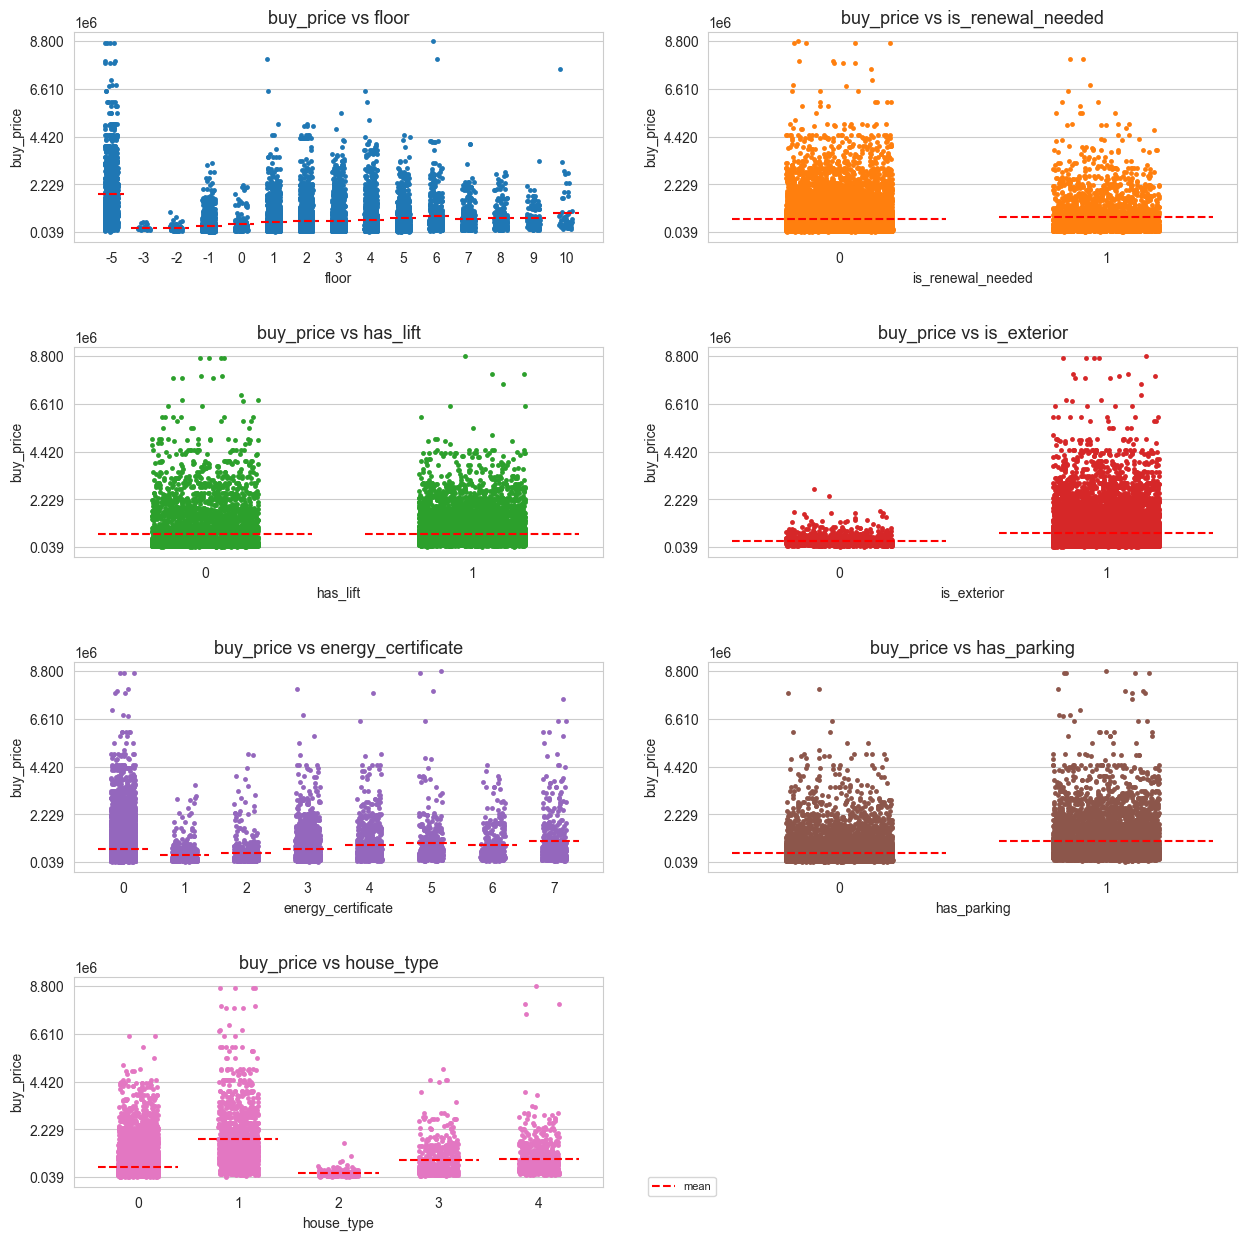

In [67]:
stripplot_matrix(df=X_Y_train_df, n_cols=2, tittle='', figsize=(15,15), jitter=0.2,
                 response=[response], predictors=cat_predictors,
                 n_yticks=5, title_height=0.93, hspace=0.5, fontsize=20,
                 statistics=['mean'], lines_width=0.8, bbox_to_anchor=(0.53, 0.1), 
                 legend_size=8, color_stats=['red'])

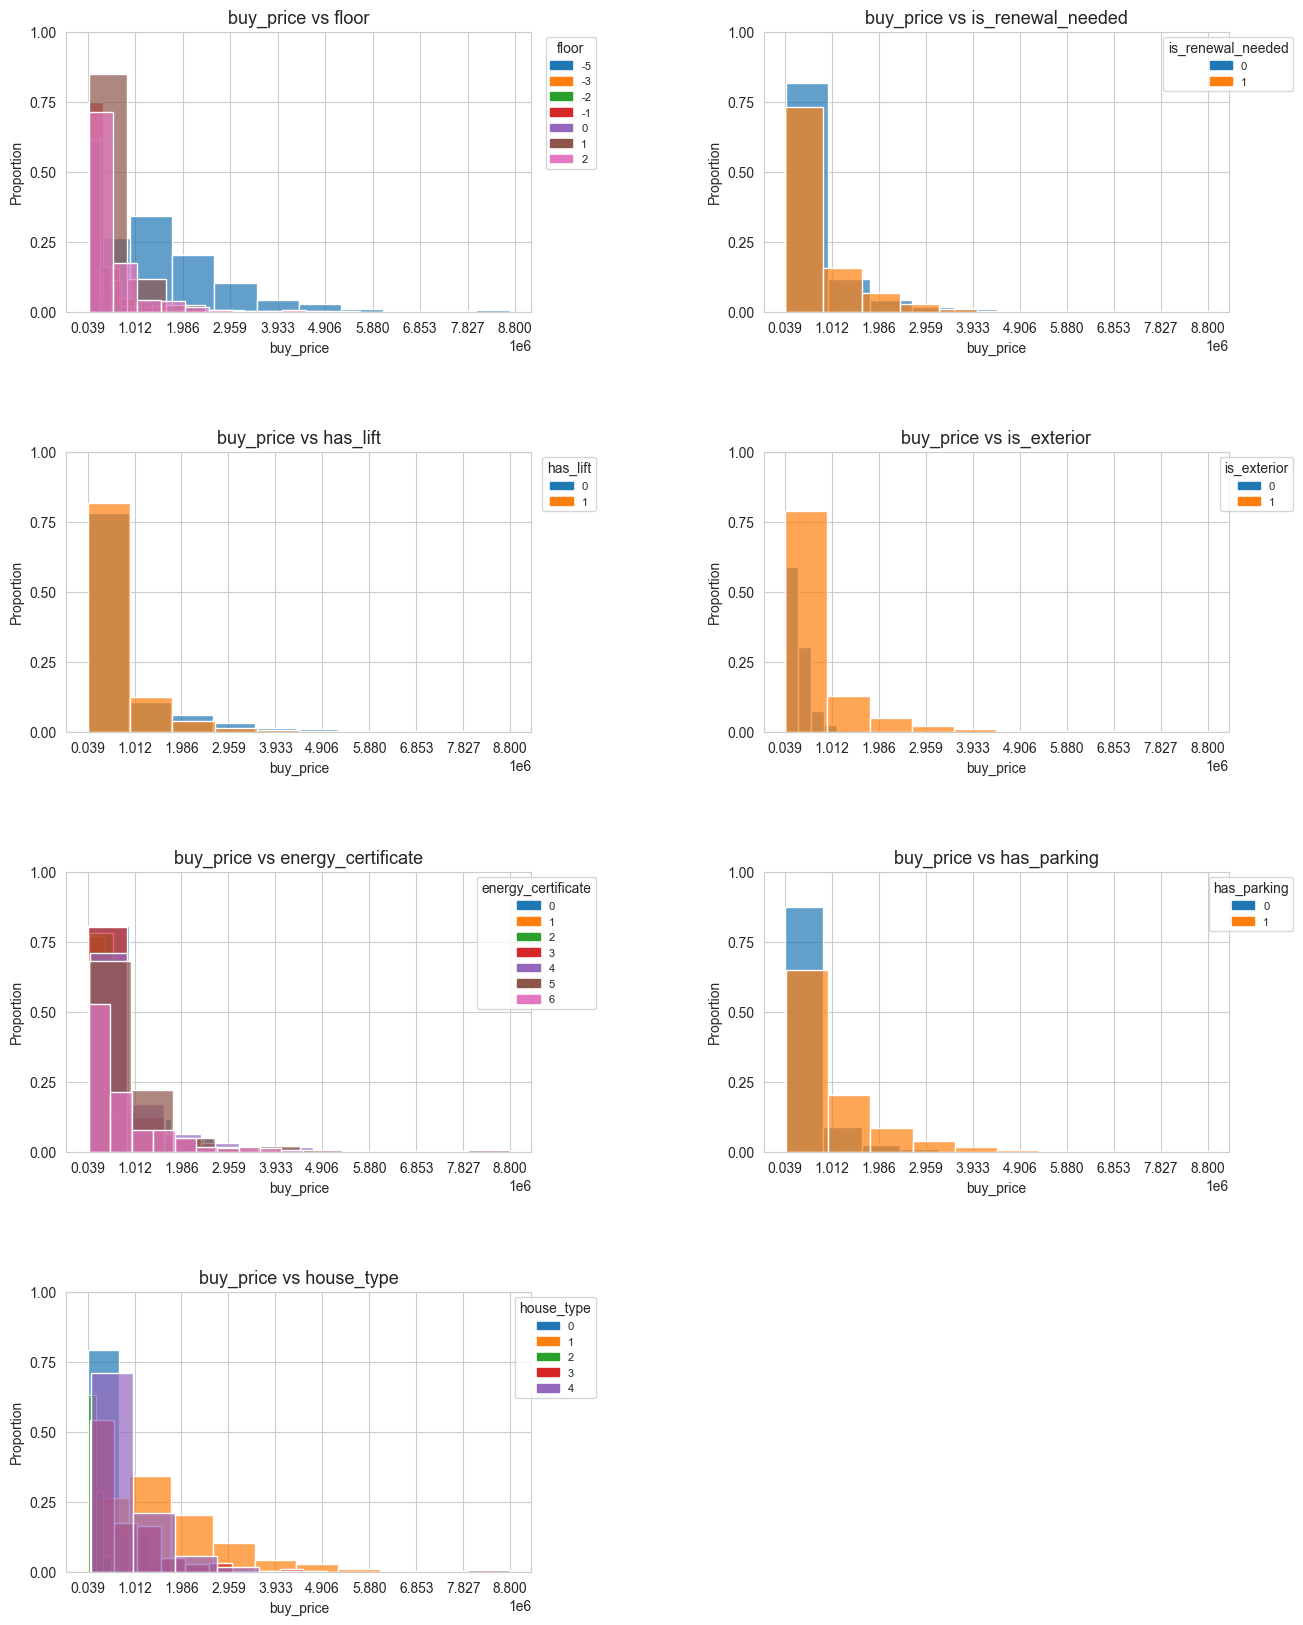

In [68]:
histogram_2D_matrix(df=X_Y_train_df, bins=10, n_cols=2, tittle='', figsize=(15,20), 
                 response=[response], predictors=cat_predictors,
                 n_yticks=5, n_xticks=10, title_height=0.93, fontsize=20,
                 bbox_to_anchor=(1.15, 1), wspace=0.5, hspace=0.5,
                 legend_size=8, transparency=0.7)

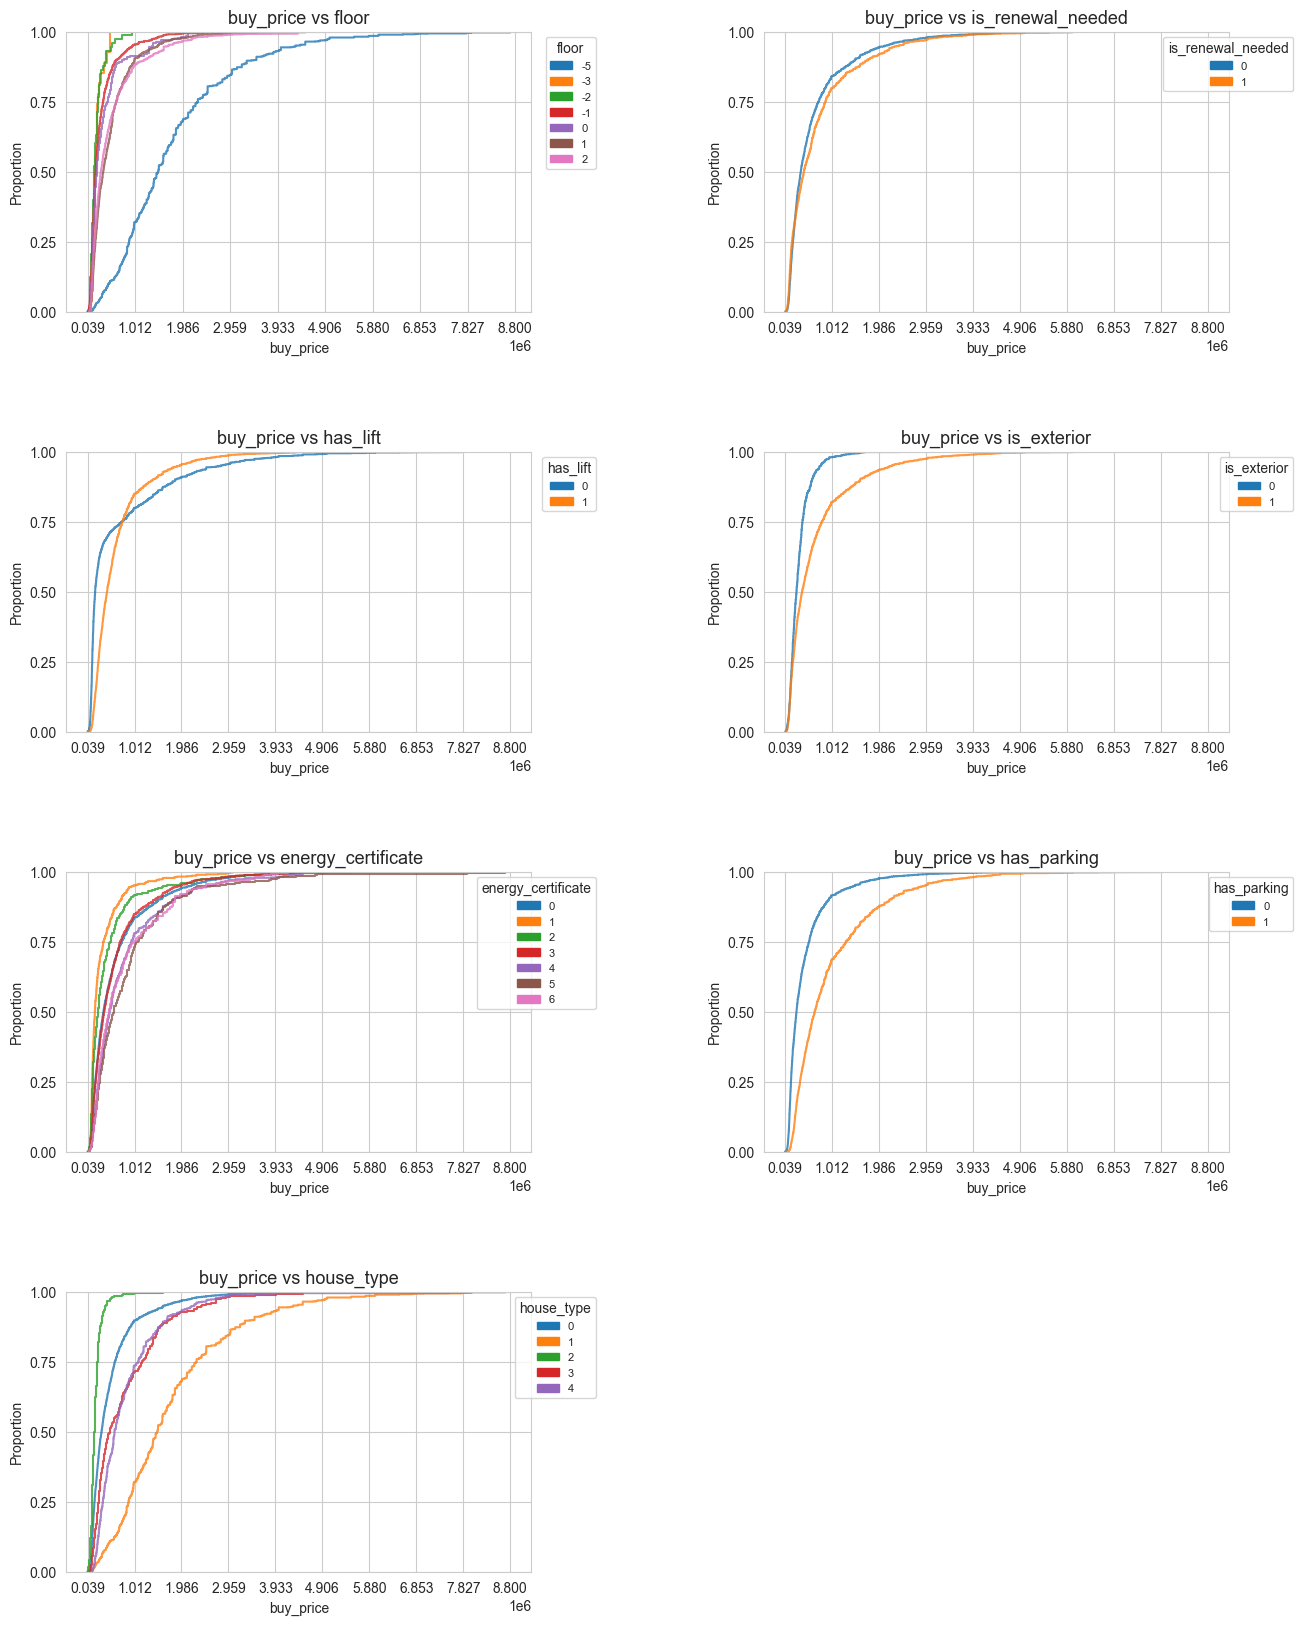

In [69]:
ecdf_2D_matrix(df=X_Y_train_df, n_cols=2, tittle='', figsize=(15,20), 
                 response=[response], predictors=cat_predictors,
                 n_xticks=10, n_yticks=5, title_height=0.93, fontsize=20,
                 bbox_to_anchor=(1.15, 1), wspace=0.5, hspace=0.5,
                 legend_size=8, transparency=0.8)

In [70]:
for col in cat_predictors:
    display(cross_quant_cat_summary(df=X_Y_train_df, quant_col=response, cat_col=col))

floor,mean_buy_price,std_buy_price,min_buy_price,Q10_buy_price,Q25_buy_price,median_buy_price,Q75_buy_price,Q90_buy_price,max_price,kurtosis_buy_price,skew_buy_price,prop_outliers_buy_price,prop_nan_buy_price
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-5.0,1.7851e6,1.2945e6,39000.0,475200.0,890000.0,1.49e6,2.3e6,3.495e6,8.7e6,4.512,1.745,0.091837,0.0
-3.0,237733.333,102940.106,115000.0,160000.0,175000.0,200000.0,250000.0,385000.0,494900.0,1.078,1.423,0.155172,0.0
-2.0,224156.014,154217.86,74000.0,93900.0,130000.0,175000.0,259000.0,415000.0,950000.0,7.028,2.398,0.067879,0.0
-1.0,323802.642,343219.37,42000.0,109000.0,140000.0,210000.0,359000.0,630000.0,3.2e6,16.575,3.51,0.105939,0.0
0.0,386954.342,415719.735,80000.0,124000.0,155000.0,230000.0,440000.0,790000.0,2.2e6,6.573,2.577,0.094352,0.0
1.0,515647.077,513707.292,61000.0,140000.0,199900.0,360000.0,630000.0,999000.0,8e6,29.949,3.92,0.083282,0.0
2.0,533162.318,610772.407,70000.0,130000.0,180000.0,315000.0,625000.0,1.2e6,5e6,14.534,3.273,0.100877,0.0
3.0,534463.084,606692.743,70000.0,130000.0,178000.0,315000.0,600000.0,1.2e6,5.5e6,10.309,2.878,0.148148,0.0
4.0,611404.858,714715.602,55000.0,130000.0,188400.0,365000.0,720000.0,1.375e6,6.5e6,11.715,3.009,0.091986,0.0


is_renewal_needed,mean_buy_price,std_buy_price,min_buy_price,Q10_buy_price,Q25_buy_price,median_buy_price,Q75_buy_price,Q90_buy_price,max_price,kurtosis_buy_price,skew_buy_price,prop_outliers_buy_price,prop_nan_buy_price
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,635567.578,759885.127,49000.0,139000.0,200000.0,365000.0,735000.0,1.495e6,8.8e6,17.864,3.422,0.095637,0.0
1.0,723705.952,840998.958,39000.0,126900.0,187000.0,430000.0,875000.0,1.75e6,8e6,11.796,2.851,0.087657,0.0


has_lift,mean_buy_price,std_buy_price,min_buy_price,Q10_buy_price,Q25_buy_price,median_buy_price,Q75_buy_price,Q90_buy_price,max_price,kurtosis_buy_price,skew_buy_price,prop_outliers_buy_price,prop_nan_buy_price
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,658804.012,1.0056e6,39000.0,109990.0,135000.0,198000.0,750000.0,1.85e6,8.7e6,11.736,2.986,0.123038,0.0
1.0,648529.815,644379.972,49000.0,180000.0,265000.0,445000.0,758000.0,1.4e6,8.8e6,16.46,3.186,0.088427,0.0


is_exterior,mean_buy_price,std_buy_price,min_buy_price,Q10_buy_price,Q25_buy_price,median_buy_price,Q75_buy_price,Q90_buy_price,max_price,kurtosis_buy_price,skew_buy_price,prop_outliers_buy_price,prop_nan_buy_price
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,335710.161,242012.879,52000.0,135000.0,185000.0,275000.0,399000.0,600000.0,2.7e6,16.453,3.052,0.06371,0.0
1.0,679795.234,800626.236,39000.0,135988.0,200000.0,395000.0,800000.0,1.599e6,8.8e6,15.223,3.174,0.08793,0.0


energy_certificate,mean_buy_price,std_buy_price,min_buy_price,Q10_buy_price,Q25_buy_price,median_buy_price,Q75_buy_price,Q90_buy_price,max_price,kurtosis_buy_price,skew_buy_price,prop_outliers_buy_price,prop_nan_buy_price
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,642185.792,753992.242,39000.0,137500.0,199000.0,369000.0,750000.0,1.5e6,8.7e6,15.746,3.209,0.102439,0.0
1.0,346668.228,428497.12,53000.0,113400.0,135000.0,190000.0,370000.0,740000.0,3.595e6,18.518,3.869,0.087467,0.0
2.0,475198.415,662838.173,66000.0,112000.0,148000.0,259000.0,515000.0,910000.0,5e6,17.032,3.785,0.109049,0.0
3.0,622401.725,710730.549,57000.0,139000.0,209000.0,385000.0,720000.0,1.45e6,8e6,17.811,3.419,0.096362,0.0
4.0,805999.855,881449.77,80000.0,169000.0,266000.0,495000.0,950000.0,1.85e6,7.8e6,11.196,2.823,0.093899,0.0
5.0,908499.322,1079620.2,70000.0,184000.0,290000.0,590000.0,1.079e6,1.8e6,8.8e6,19.892,3.787,0.07855,0.0
6.0,805822.84,815363.793,70000.0,185000.0,268000.0,482000.0,998000.0,1.85e6,4.5e6,4.193,2.007,0.081319,0.0
7.0,1.0018e6,1.1524e6,80000.0,175000.0,315000.0,570620.0,1.15e6,2.5e6,7.525e6,7.264,2.501,0.060302,0.0


has_parking,mean_buy_price,std_buy_price,min_buy_price,Q10_buy_price,Q25_buy_price,median_buy_price,Q75_buy_price,Q90_buy_price,max_price,kurtosis_buy_price,skew_buy_price,prop_outliers_buy_price,prop_nan_buy_price
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,461199.273,555863.208,39000.0,125000.0,161000.0,275000.0,540000.0,945000.0,8e6,26.332,4.16,0.076561,0.0
1.0,993549.052,973058.005,61000.0,235000.0,350000.0,650000.0,1.3e6,2.2e6,8.8e6,9.997,2.546,0.060584,0.0


house_type,mean_buy_price,std_buy_price,min_buy_price,Q10_buy_price,Q25_buy_price,median_buy_price,Q75_buy_price,Q90_buy_price,max_price,kurtosis_buy_price,skew_buy_price,prop_outliers_buy_price,prop_nan_buy_price
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,518594.384,569854.249,42000.0,130000.0,185000.0,330000.0,605000.0,1.06e6,6.5e6,15.006,3.269,0.08299,0.0
1.0,1.7851e6,1.2945e6,39000.0,475200.0,890000.0,1.49e6,2.3e6,3.495e6,8.7e6,4.512,1.745,0.052045,0.0
2.0,210529.651,143737.952,52990.0,99900.0,135000.0,185000.0,246500.0,330000.0,1.6e6,35.615,4.682,0.052851,0.0
3.0,810144.684,780032.508,92260.0,169000.0,270000.0,495000.0,1.175e6,1.75e6,5e6,5.527,2.054,0.046818,0.0
4.0,846746.026,826488.552,120000.0,247000.0,359000.0,598000.0,1.095e6,1.69e6,8.8e6,32.417,4.422,0.045175,0.0


## **Linear Regression Model**

### **Why Linear regression?**

The main usefulness of the linear regression model is to predict the
values of a **quantitative** variable, called **response variable**,  depending on the values of other, **quantitative** or **categorical** variables ,
called **predictors**.

The other important usefulness of this model is to make inference, in other words, analyze the relation between the response variable and the predictors.

### **Assumptions**

We have a response variable $\mathcal{Y}$ and $p$ predictors $\mathcal{X} = (\mathcal{X}_1,\dots, \mathcal{X}_p).$ 

We also have an $n$ size sample of this variables: $\hspace{0.1cm} Y\in \mathbb{R}^n, \hspace{0.2cm} X=(X_1,\dots , X_p)\in \mathbb{R}^{n\times p}$



- The model is defined as follows:

    $$y_i \hspace{0.1cm} =  \hspace{0.1cm} \beta_0 + x_i^\prime \cdot \beta \hspace{0.05cm}+\hspace{0.05cm}  \varepsilon_i \hspace{0.1cm} =  \hspace{0.1cm}  \beta_0 + \beta_1 \cdot x_{i1} + \dots + \beta_p \cdot x_{ip} + \varepsilon_i$$

    Where:

    - $x_i = (x_{i1},\dots, x_{ip})^\prime \in \mathbb{R}^p$

    - $\beta = (\beta_1, \dots, \beta_p)^\prime  \in \mathbb{R}^p$

    - $\varepsilon_i$ is the residual term.

- The residual term has to fulfill the following properties:

    - $E[\varepsilon_i]=0$
    
    - $Var(\varepsilon_i)\hspace{0.05cm} =  \hspace{0.05cm}\sigma^2$
  
   - $\varepsilon_i \sim N(0,\sigma)$ 
  
   - $cov(\varepsilon_i , \varepsilon_j)\hspace{0.05cm} = \hspace{0.05cm}0  \hspace{0.1cm} ,  \hspace{0.1cm} \forall i\neq j$ 

-  Additional assumptions:

   -  $n  \hspace{0.1cm}> \hspace{0.1cm} p+1\hspace{0.3cm}$  $(\text{nº observations} \hspace{0.05cm}> \hspace{0.05cm} \text{nº of beta coefficients})$

   -  $Rg(X) \hspace{0.05cm}= \hspace{0.05cm}p+1$

   These additional assumptions are important because of the *dimensionality problem*.

### **Assumptions consequences**

 

   -  $y_i$ is a random variable because  $\varepsilon_i$ is a random variable

   -  $E[y_i] \hspace{0.05cm} = \hspace{0.05cm} \textbf{x}_i^T \cdot \boldsymbol{\beta}$

   -  $Var(y_i) \hspace{0.05cm} = \hspace{0.05cm} \sigma^2$

   -  $y_i \sim N(\hspace{0.02cm} \mathbf{x}_i^T  \cdot \beta \hspace{0.03cm} , \hspace{0.1cm} \sigma^2 \hspace{0.02cm} )$

   -  $cov(y_i , y_j)\hspace{0.05cm} = \hspace{0.05cm}0  \hspace{0.1cm},\hspace{0.15cm} \forall i\neq j$



### **Matrix representation of the basic assumption** <a class="anchor" id="8"></a>




- $Y \hspace{0.05cm} = \hspace{0.05cm} \beta_0 + X\cdot \beta \hspace{0.05cm} + \hspace{0.05cm}\varepsilon$

- $\varepsilon_i \sim N(0,\sigma^2) \hspace{0.05cm} , \hspace{0.1cm} \forall \hspace{0.1cm} i=1,...,n $
  
- $cov(\varepsilon_i , \varepsilon_j)\hspace{0.05cm} = \hspace{0.05cm}0 \hspace{0.05cm} , \hspace{0.1cm} \forall \hspace{0.1cm} i\neq j =1,...,n $

   Where:

   - $\varepsilon  =(\varepsilon_{1}, \varepsilon_{2}, ..., \varepsilon_{n})^\prime$

### **Coefficient estimation**

Parameters $(\beta_0, \beta)$ are estimated by Maximum Likelihood or Ordinary Least Square (OLS). Both are equivalent under the previous assumptions.

$$\widehat{\beta}_0, \widehat{\beta} \hspace{0.1cm} = \hspace{0.1cm} \text{arg}  \hspace{0.1cm}\underset{\beta_0, \beta}{\text{Min}} \hspace{0.1cm}  \sum_{i=1}^{n} \hspace{0.07cm}(y_i - \beta_0 + x_i^\prime \cdot \beta)^2$$

The solution to this problem is:

$$\left(\widehat{\beta}_0, \widehat{\beta}^\prime\right)^\prime  \hspace{0.1cm} = \hspace{0.1cm} (X^\prime \cdot X)^{-1} \cdot X^\prime \cdot Y$$

**Interpretation :**

- $\widehat{y} = \widehat{\beta}_0 + x^\prime \cdot \widehat{\beta} \hspace{0.05cm},\hspace{0.1cm} x\in \mathbb{R}^p\hspace{0.05cm}$ is the hyperplane that **minimize** the **euclidean distance** between the values of the response variable $(y_i)$ and the projections of these values onto that hyperplane  $\hspace{0.04cm}\widehat{y}_i = \widehat{\beta}_0 + x_i^\prime \cdot \widehat{\beta} \hspace{0.04cm} .$

![image.png](images/p1.png)

We can estimate a Linear regression model in `Python` using `statsmodels`, a fantastic library to implement statistical models.



The following code is a class to perform linear regression using `statsmodels` implementation but  with the possibility of including categorical predictors as dummy variables and interactions between the predictors.



In [72]:
class linear_model :

    def __init__(self, X, Y):

        if isinstance(X, pl.DataFrame):
            X = X.to_pandas()
        if isinstance(Y, pl.DataFrame):
            Y = Y.to_pandas()

        X = X.reset_index(drop=True)   
        Y = Y.reset_index(drop=True)    

        self.X = X
        self.Y = Y

    def dummies(self, X, pred_to_dummies):

        X = transform_to_dummies(X, cols_to_dummies=pred_to_dummies, drop_first=True)
        X = X.to_pandas()
        self.pred_to_dummies = pred_to_dummies
        return X

    def interactions(self, X, interactions_to_add):

        X_inter = pd.DataFrame()
        x = interactions_to_add
        if self.pred_to_dummies is not None:
            X_initial = self.X # X without any changes
            interactions_to_add = [(x[i][0], x[i][1]+f'_{j}') 
                                   for i in range(0, len(x)) 
                                   for j in np.sort(X_initial[x[i][1]].unique())[1:]]

        for quant, cat in interactions_to_add:
            X_inter[f'{quant}:{cat}'] = X[quant]*X[cat]
        X = pd.concat((X, X_inter), axis=1)
        return X

    def fit(self, pred_to_dummies=None, interactions_to_add=None):

        X = self.X
        self.interactions_to_add = interactions_to_add
        self.pred_to_dummies = pred_to_dummies

        if pred_to_dummies is not None:
            X = self.dummies(X, pred_to_dummies=pred_to_dummies)
        if interactions_to_add is not None:
            X = self.interactions(X, interactions_to_add=interactions_to_add)
        self.X_modified = X

        poisson = sm.OLS(endog=self.Y, exog=X)
        self.linear_fit = poisson.fit()
    
    def predict(self, X):

        pred_to_dummies = self.pred_to_dummies
        interactions_to_add = self.interactions_to_add

        if pred_to_dummies is not None:
            X = self.dummies(X, pred_to_dummies=pred_to_dummies)
        if interactions_to_add is not None:
            X = self.interactions(X, interactions_to_add=interactions_to_add)
        
        Y_hat = self.linear_fit.predict(X)
        return Y_hat

Just to see how to use the class and their summary output we are going to train four full linear models. Full in the sense that hey will include all the available predictors, but we will distinguish four cases:

1. Full model with dummies for categorical predictors and some interactions

2. Full model without dummies but with interactions.
3. Full model with dummies but without interactions.
4. Full model without dummies and interactions.

In [73]:
# Statmodels only reads Pandas dataframes, for now.
X_train = X_train.to_pandas()
Y_train = Y_train.to_pandas()

In [74]:
# Full model - interactions - dummies
full_model_inter_dummies = linear_model(Y=Y_train, X=X_train)
interactions = [('n_rooms', 'is_exterior'), ('sq_mt_built', 'is_exterior'), ('sq_mt_built', 'has_lift'), ('sq_mt_built', 'has_parking')]
full_model_inter_dummies.fit(pred_to_dummies=cat_predictors, interactions_to_add=interactions)
results_full_model_inter_dummies = full_model_inter_dummies.linear_fit.summary()

In [75]:
# Full model - interactions 
full_model_inter = linear_model(Y=Y_train, X=X_train)
interactions = [('n_rooms', 'is_exterior'), ('sq_mt_built', 'is_exterior'), ('sq_mt_built', 'has_lift'), ('sq_mt_built', 'has_parking')]
full_model_inter.fit(pred_to_dummies=None, interactions_to_add=interactions)
results_full_model_inter = full_model_inter.linear_fit.summary()

In [76]:
# Full model - dummies
full_model_dummies = linear_model(Y=Y_train, X=X_train)
full_model_dummies.fit(pred_to_dummies=cat_predictors, interactions_to_add=None)
results_full_model_dummies = full_model_dummies.linear_fit.summary()

In [77]:
# Full model - basic - not interactions - not dummies
full_model_basic = linear_model(Y=Y_train, X=X_train)
full_model_basic.fit(pred_to_dummies=None, interactions_to_add=None)
results_full_model_basic = full_model_basic.linear_fit.summary()

We are going to print the summaries of the respective models just to see how they look like.

In [78]:
print(results_full_model_inter_dummies)

                                 OLS Regression Results                                
Dep. Variable:              buy_price   R-squared (uncentered):                   0.858
Model:                            OLS   Adj. R-squared (uncentered):              0.858
Method:                 Least Squares   F-statistic:                              2478.
Date:                Fri, 29 Dec 2023   Prob (F-statistic):                        0.00
Time:                        10:07:47   Log-Likelihood:                     -2.1718e+05
No. Observations:               15217   AIC:                                  4.344e+05
Df Residuals:                   15180   BIC:                                  4.347e+05
Df Model:                          37                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

In [79]:
print(results_full_model_inter)

                                 OLS Regression Results                                
Dep. Variable:              buy_price   R-squared (uncentered):                   0.855
Model:                            OLS   Adj. R-squared (uncentered):              0.855
Method:                 Least Squares   F-statistic:                              5595.
Date:                Fri, 29 Dec 2023   Prob (F-statistic):                        0.00
Time:                        10:07:47   Log-Likelihood:                     -2.1734e+05
No. Observations:               15217   AIC:                                  4.347e+05
Df Residuals:                   15201   BIC:                                  4.348e+05
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [80]:
print(results_full_model_dummies)

                                 OLS Regression Results                                
Dep. Variable:              buy_price   R-squared (uncentered):                   0.834
Model:                            OLS   Adj. R-squared (uncentered):              0.834
Method:                 Least Squares   F-statistic:                              2317.
Date:                Fri, 29 Dec 2023   Prob (F-statistic):                        0.00
Time:                        10:07:47   Log-Likelihood:                     -2.1835e+05
No. Observations:               15217   AIC:                                  4.368e+05
Df Residuals:                   15184   BIC:                                  4.370e+05
Df Model:                          33                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [81]:
print(results_full_model_basic)

                                 OLS Regression Results                                
Dep. Variable:              buy_price   R-squared (uncentered):                   0.833
Model:                            OLS   Adj. R-squared (uncentered):              0.833
Method:                 Least Squares   F-statistic:                              6323.
Date:                Fri, 29 Dec 2023   Prob (F-statistic):                        0.00
Time:                        10:07:47   Log-Likelihood:                     -2.1841e+05
No. Observations:               15217   AIC:                                  4.368e+05
Df Residuals:                   15205   BIC:                                  4.369e+05
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

### **Standard deviation of coefficients**

The precision of beta coefficients estimations is given by the
standard deviation of their estimators:

$$s_d(\widehat{\beta}_j)=\sqrt{\sigma^2 \cdot q_{jj}}$$

where:

- $q_{jj}\hspace{0.05cm} = diag\left( (X^T \cdot X)^{-1} \right)[j+1]\hspace{0.05cm}$  is the $j+1$ element    of the principal diagonal of the matrix $(X^T \cdot X)^{-1}$  $\hspace{0.01cm} , \hspace{0.05cm}$ for $\small{j=0,1,\dots,p}$ .

To estimate $sd(\widehat{\beta}_j)$ we need to estimate $\sigma^2$, i.e, the variance of the error term $\varepsilon_i$.

We can estimate it as follows:

$$\widehat{\sigma}^2 \hspace{0.1cm}=\hspace{0.1cm} \dfrac{1}{n-p-1} \cdot \sum_{i=1}^{n} \hspace{0.05cm}\hat{\varepsilon}_i^2   
$$

where:
- $RSS = \sum_{i=1}^{n} \hspace{0.05cm}\widehat{\varepsilon}_i^2$ is the residual sum of squares.

- $\widehat{\varepsilon}_i =  y_i - \widehat{y}_i$ is the estimation of the $i$-th residual term.

Then, we have the following estimation for the standard deviation of the coefficients:

$$\widehat{s_d}(\widehat{\beta}_j)=\sqrt{\widehat{\sigma}^2 \cdot q_{jj}}$$


**Why is the variance of the coefficient estimators important?**


The standard deviation of a coefficient estimator indicates how much
the estimation of that coefficient varies, in mean, when the model is  trained with many different samples.

Suppose many samples are obtained, and with each of them a linear
regression model is trained. Then, we get many estimations of the model
coefficient $\widehat{\beta}_j$, one with each sample.

Then, $s_d(\widehat{\beta}_j)$ indicates how much
$\widehat{\beta}_j$ varies from one sample to another, in mean.



**Interpretation:**

- If the standard deviation is **high**, this indicates that will be obtained
big differences when $\beta_j$ is estimate with $\widehat{\beta}_j$
depending on the sample that is used for estimate it, that means
estimator $\widehat{\beta}_j$ is **imprecise**, because it will be much
dispersion of the values of $\widehat{\beta}_j$ respect to the mean.

- On the contrary, if the standard deviation is **low**, this indicates that
will be obtained small differences when $\beta_j$ is estimate with
$\widehat{\beta}_j$ depending on the sample that is used for estimate it,
that means estimator $\widehat{\beta}_j$ is **precise**, because it will be little
dispersion of the values of $\widehat{\beta}_j$ respect to the mean.

- In addition, $\widehat{s_d}(\widehat{\beta}_j)$ allows to define a confidence interval for $\widehat{\beta}_j$ estimator .


We can obtain the estimation fo the standard deviation of coefficient estimators with our class as follows:

In [82]:
full_model_inter_dummies.linear_fit.bse

sq_mt_built                    342.961695
n_rooms                      12727.596343
n_bathrooms                   4883.094974
n_floors                     11493.166017
sq_mt_allotment                 11.454317
floor_-2                     45685.141817
floor_-3                     74314.873388
floor_-5                     15959.232517
floor_0                      28964.054054
floor_1                      11861.824556
floor_10                     53666.317778
floor_2                      11961.359039
floor_3                      12769.649023
floor_4                      13566.003037
floor_5                      16106.923393
floor_6                      18701.565813
floor_7                      22382.217113
floor_8                      27512.954519
floor_9                      34577.619792
is_renewal_needed_1           8443.816143
has_lift_1                   10273.791241
is_exterior_1                15569.325847
energy_certificate_1         16050.032312
energy_certificate_2         18377

### **Confidence intervals for  coefficients**

Confidence intervals for beta coefficients at a level $1-\alpha$ can be defined as follows:

 $$CI(\beta_j)_{1-\alpha} = \left[\widehat{\beta}_j \hspace{0.1cm} \pm \hspace{0.1cm} t^{n-p-1}_{\alpha/2}\cdot \widehat{s_d}(\widehat{\beta}_j)\right]$$

**Observation:**

The smaller $\widehat{s_d}(\widehat{\beta}_j)$, the smaller $CI(\beta_j)$.

Using our class these confidence intervals can be obtained as follows:

In [83]:
betas_CI = full_model_inter_dummies.linear_fit.conf_int(alpha=0.05)
betas_CI.columns = ['2.5%', '97.5%']
betas_CI

,2.5%,97.5%
sq_mt_built,860.601179,2205.093522
n_rooms,-48290.274169,1604.965066
n_bathrooms,106488.712368,125631.619276
n_floors,-19573.123999,25482.851420
sq_mt_allotment,-5.309497,39.594179
floor_-2,-67947.157168,111149.588124
floor_-3,-117142.811317,174189.368494
floor_-5,148561.896433,211125.926824
floor_0,-78223.279453,35322.779618
floor_1,22269.505846,68770.711419


### **Goodness of fit**

####  **R-square** 

The R-square is a measure of the goodness of fit of the linear regression model to the training data.

$$R^2 \hspace{0.05cm}=\hspace{0.05cm} \dfrac{\hspace{0.07cm}RegSS\hspace{0.07cm}}{TSS} \hspace{0.05cm}=\hspace{0.05cm} \dfrac{\hspace{0.07cm}TSS-RSS\hspace{0.07cm}}{TSS} \hspace{0.05cm}=\hspace{0.05cm} 1 - \dfrac{RSS}{TSS}$$

Where:

-  **Total Sum Squares** 

$$
TSS \hspace{0.1cm} = \hspace{0.1cm} \sum_{i=1}^n ( y_i - \overline{y})^2
$$
 
-   **Residual Sum Squares** 

$$
RSS=  \sum_{i=1}^n \widehat{\varepsilon}_i^2 =  \sum_{i=1}^n ( y_i - \hat{y}_i)^2
$$
 
-  **Regression Sum Squares** 

$$ 
RegSS =  \sum_{i=1}^n ( \hat{y}_i - \overline{y} )^2
$$


It can be proved that:

$$
TSS=RSS+RegSS
$$
 
where:

-  $TSS \hspace{0.05cm}$ is the total variance of the response variable $Y$

-  $RegSS \hspace{0.05cm}$ is the variance of the response variable $Y$ **explained** by the
    model using $X$

-  $RSS \hspace{0.05cm}$ is the variance of the response variable $Y$ **not explained** by the
    model using $X$




**Properties:**

-   $R^2$ is the total variance of the response explaining by the linear regression model by mean of the predictors.

- $R^2 \in \left[ 0 , 1 \right]$

For this reason, $\hspace{0.01cm}R^2\hspace{0.01cm}$ is used as a measure of how well the model fits the response variable. 

 

**Interpretation:**

The $\hspace{0.01cm}R^2\hspace{0.01cm}$ interpretation is the following:

-   If $\hspace{0.01cm}R^2\hspace{0.01cm}$ is close to $1$, this means that the model is fitting well the response data.

-   If $\hspace{0.01cm}R^2\hspace{0.01cm}$ is close to $0$, this means that the model is fitting badly the response data.


We can obtain it using our class as follows:

In [84]:
full_model_inter_dummies.linear_fit.rsquared

0.8579358772571637

#### **Adjusted R-square** 

 

The $R^2$ has some problems:

-  $\hspace{0.1cm} R^2$ always increase when increase the number of predictors,
    although they are not significative.

-  It´s possible estimate two models with the same prediction power but
    with different $\hspace{0.1cm}R^2$

 
For avoid the disadvantages of $\hspace{0.1cm}R^2\hspace{0.1cm}$ was created the adjusted $\hspace{0.1cm}R^2\hspace{0.1cm}$ ,
denoted as $\widehat{R^2}$, and defined as: 

$$
 R^2_{adj} =  1 - \dfrac{RSS/(n-p-1)}{TSS/(n-1)} = 1 - \left( 1- R^2 \right) \cdot \dfrac{n-1}{n-p}
$$

This metric doesn't grow when including irrelevant predictors, because if $\hspace{0.1cm} RSS\hspace{0.1cm}$ is small because of $\hspace{0.1cm}p\hspace{0.1cm}$ is large, then  $\hspace{0.1cm}1/(n-p-1)\hspace{0.1cm}$ will be large compensating the $\hspace{0.01cm}RSS\hspace{0.01cm}$ value
 

We can obtain it using our class as follows:

In [85]:
full_model_inter_dummies.linear_fit.rsquared_adj

0.8575896076562753

### **Global Significance Test (ANOVA)**

The **test of model global significance** is also called **ANOVA** test, and is defined by the following hypothesis :
 
$$
\hspace{-0.7 cm} H_0: \hspace{0.1cm} \beta_1=\dots =\beta_p=0 \\
H_1: \hspace{0.1cm} \beta_j \neq 0 \hspace{0.05cm},\hspace{0.15cm} \exists \ j=1,\dots ,p 
$$

**Statistic:**

The **test statistic** for the ANOVA test is the following:

 
$$
F_{exp|H_0}= \dfrac{(TSS-RSS)/p}{RSS/(n-p-1)} = \dfrac{RegSS/p}{RSS/(n-p-1)} \hspace{0.05cm} \sim \hspace{0.05cm}  F_{\hspace{0.05cm}p,\hspace{0.05cm} n-p-1}
$$




**Decision Rule:**

 

-   Based on test statistic: 
   
    $$
    \text{Reject} \hspace{0.05cm} H_0   \hspace{0.1cm} \Leftrightarrow \hspace{0.1cm}  F_{exp|H_0} > F_{\alpha}^{\hspace{0.1cm}p,\hspace{0.05cm} n-p-1}
    $$
     
    where:

    $$
    P(F_{\hspace{0.05cm}p,\hspace{0.05cm} n-p-1} > F_{\alpha}^{\hspace{0.1cm}p,\hspace{0.05cm} n-p-1} ) = \alpha
    $$
    
-   Based on p-value:

    $$
    \text{Reject} \hspace{0.05cm} H_0 \hspace{0.1cm} \Leftrightarrow \hspace{0.1cm} p\text{-value} < \alpha
    $$
 
    where:

    $$
    p\text{-value} =  P(F_{\hspace{0.05cm}p,\hspace{0.05cm} n-p-1} \geq F_{exp|H_0} )
    $$

We can obtain the observed value of the statistic and the pvalue of the test from our class as follows:

In [86]:
full_model_inter_dummies.linear_fit.fvalue

2477.6528897026333

In [87]:
full_model_inter_dummies.linear_fit.f_pvalue

0.0

### **Prediction**

Once we have estimated the model parameters we can make predictions on the response using data of the predictors.

The prediction of the response for individuals with the value $x_i \in \mathbb{R}^p$  for the predictors is:

$$\widehat{y}_i \hspace{0.05cm}=\hspace{0.05cm} \widehat{\beta}_0 + x_i^\prime \cdot \widehat{\beta} $$

In [88]:
# Full model - interactions - dummies
full_model_inter_dummies = linear_model(Y=Y_train, X=X_train)
interactions = [('n_rooms', 'is_exterior'), ('sq_mt_built', 'is_exterior'), ('sq_mt_built', 'has_lift'), ('sq_mt_built', 'has_parking')]
full_model_inter_dummies.fit(pred_to_dummies=cat_predictors, interactions_to_add=interactions)
# Computing predictions
Y_train_hat = full_model_inter_dummies.predict(X_train)
# Computing RMSE
np.sqrt(np.mean((Y_train_hat - Y_train.to_numpy())**2))

381995.050363493

### **Predictors Selection**

In this section we are going to explore several methods to select predictors.

Given a data set with $p$ predictors, the number of possible linear regression model that can be trained with a subset (all included) of them is:

$$\sum_{k=1}^p C(p,k) = \sum_{k=1}^p \dfrac{p!}{k! (p-k)!}$$

Where: 

$$C(p,k) = \dfrac{p!}{k! (p-k)!}$$
is the  number of possible combinations of $k$ objects selected from a set of $p$ objects, without repetition and where the order does not matter, is given by the binomial coefficient:



In [89]:
def binom(p,k) :
    return factorial(p) / (factorial(k)*factorial(p-k))

In [90]:
p = X_train.shape[1]
np.sum([binom(p,k) for k in range(1,p+1)])

4095.0

In this case we can train 4095 different linear regression model with our data set, that has $p=12$ predictors.

So, we are interested in a way to select the "best" combination of predictors. There is no definitive method, so, we will see several options.

#### **Significance Test**

The (individual) significance test (ST) for the predictor $\mathcal{X}_j$ consists in testing the following hypothesis

\begin{cases}
H_0 : \beta_j = 0 \\
H_1 : \beta_j \neq 0
\end{cases}


**Statistic:**

$$t_{exp} \hspace{0.1cm}=\hspace{0.1cm} \dfrac{\widehat{\beta}_j - \beta_j}{\widehat{s_d}(\widehat{\beta}_j)} \hspace{0.1cm}\underset{H_0}{=}\hspace{0.1cm} \dfrac{\widehat{\beta}_j }{\widehat{s_d}(\widehat{\beta}_j)} \hspace{0.1cm}\sim\hspace{0.1cm} t_{n-p-1}$$

**p-value:**

$$\text{p-value} = P\left( t_{n-p-1} \hspace{0.1cm}\geq\hspace{0.1cm} \dfrac{\widehat{\beta}_j }{\widehat{s_d}(\widehat{\beta}_j)}\right)$$

**Decision rule based in p-value:**

- If $\hspace{0.1cm}\text{p-value} < \alpha \hspace{0.1cm} \Rightarrow\hspace{0.1cm}$ Reject $H_0 \hspace{0.1cm}\Rightarrow\hspace{0.1cm}$ predictor $\mathcal{X}_j$  is **significative** to explain the response.

- If $\hspace{0.1cm}\text{p-value}  \geq \alpha \hspace{0.1cm}\Rightarrow\hspace{0.1cm}$ Not Reject $H_0 \hspace{0.1cm}\Rightarrow\hspace{0.1cm}$ predictor $\mathcal{X}_j$  is **not significative** to explain the response.

**Decision rule basede in confidence intervals:**

This test can be performed with the confidence intervals of the coefficients as follows:

- If $\hspace{0.1cm}0\in CI(\beta_j)\hspace{0.1cm}\Rightarrow\hspace{0.1cm}$ Not reject $H_0$
- If $\hspace{0.1cm}0\in CI(\beta_j)\hspace{0.1cm}\Rightarrow\hspace{0.1cm}$  Reject $H_0$

  Where:
  - $P\left(t_{n-p-1} > t^{n-p-1}_{\alpha/2} \right) = \alpha/2$

The following function allow us to extract the significant predictors of a given linear regression model according to the above test.

In [91]:
def significant_test(model, alpha=0.05, figsize=(5, 6)) :

    pvalues = model.linear_fit.pvalues.values
    pvalues = pvalues[0:len(pvalues)-1]
    predictors = model.linear_fit.pvalues.index.to_numpy()
    predictors = predictors[0:len(predictors)-1]
    significant_results = pvalues < alpha

    significant_predictors = predictors[significant_results==True]
    not_significant_predictors = predictors[significant_results==False]
    significant_results_str = np.array([str(x) for x in significant_results])

    plt.figure(figsize=figsize)
    ax = sns.scatterplot(x=significant_results_str, y=predictors, color='red', s=100)
    ax = sns.scatterplot(x=significant_results_str[significant_results==True], 
                         y=predictors[significant_results==True], color='blue', s=100)
    plt.title('Significance Test', size=15)
    ax.set_ylabel('Predictors', size=12)
    ax.set_xlabel('Significant', size=12)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=11)
    ax.set_xlim(-0.5, 1.5) 
    plt.show()

    return significant_predictors, not_significant_predictors

The idea is to applied this method to the full model (the one that include all the predictors) to identify which of them are not significative (according to the above test), and therefore we will select one combination of predictors, the significative one.

Since we have four full models, as we explained before, we will apply the test to all of them, and we will obtain a "final" set of predictors in each case.

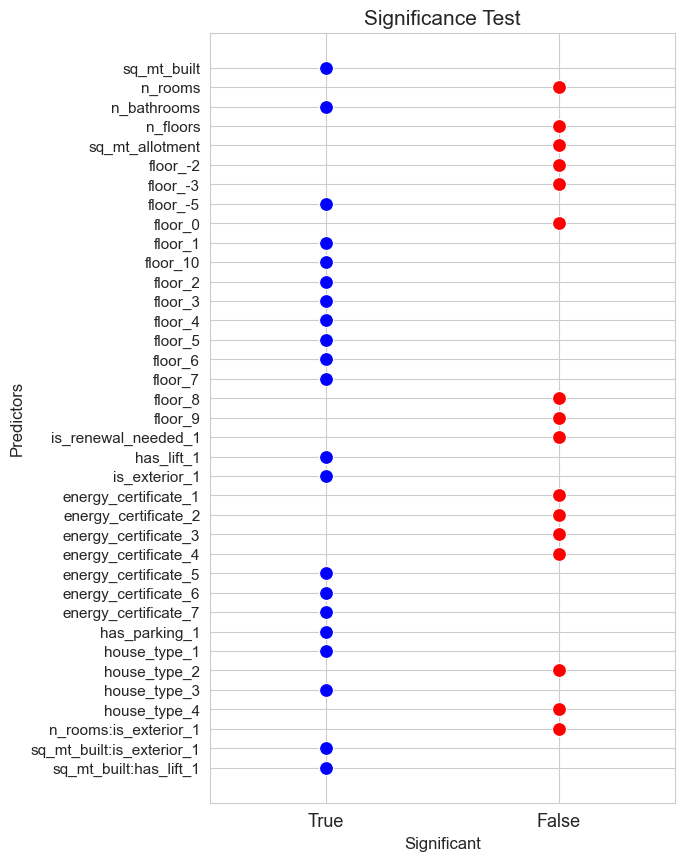

In [92]:
# Full model - interactions - dummies
significant_pred_model_inter_dummies_ST, not_significant_pred_model_inter_dummies_ST = significant_test(model=full_model_inter_dummies, alpha=0.05, figsize=(6,10))

Given a categorical predictor, if at least one dummy is significative, we consider the predictor significative. And the same for the interactions.


In [93]:
def recognition(initial_list):
    output_list = []
    for x in initial_list :
        try :
            int(x.split('_')[len(x.split('_'))-1]) 
            list_strings = x.split('_')[:len(x.split('_'))-1]
            output_list.append('_'.join(list_strings))
        except:
            output_list.append(x)
    output_list = list(set(output_list))
    return np.array(output_list)

In [94]:
predictors_selected, interactions_selected, pred_to_dummies = {}, {}, {}

In [95]:
significant_pred_model_inter_dummies_ST = recognition(significant_pred_model_inter_dummies_ST)
not_significant = recognition(not_significant_pred_model_inter_dummies_ST)
not_significant_pred_model_inter_dummies_ST = np.array([x for x in not_significant if x not in significant_pred_model_inter_dummies_ST]) 

predictors_selected['ST_inter_dummies'] = [x for x in significant_pred_model_inter_dummies_ST if ':' not in x]
interactions_selected['ST_inter_dummies'] = [(x.split(':')[0], x.split(':')[1]) for x in significant_pred_model_inter_dummies_ST  if ':' in x]
pred_to_dummies['ST_inter_dummies'] = [x for x in cat_predictors if x in predictors_selected['ST_inter_dummies']]

In [96]:
predictors_selected['ST_inter_dummies'] 

['sq_mt_built',
 'is_exterior',
 'floor',
 'n_bathrooms',
 'house_type',
 'energy_certificate',
 'has_parking',
 'has_lift']

In [97]:
interactions_selected['ST_inter_dummies'] 

[('sq_mt_built', 'is_exterior'), ('sq_mt_built', 'has_lift')]

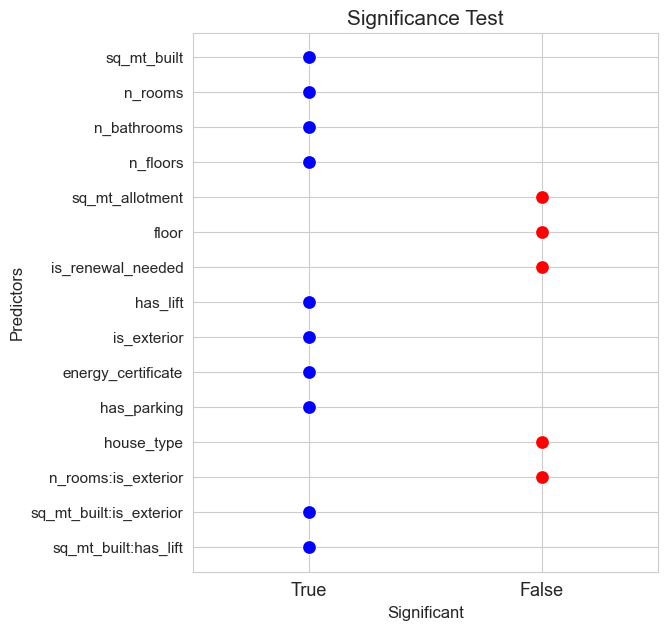

In [98]:
# Full model - interactions 
significant_pred_model_inter_ST, not_significant_pred_model_inter_ST = significant_test(model=full_model_inter, alpha=0.05, figsize=(6,7))

In [99]:
predictors_selected['ST_inter'] = [x for x in significant_pred_model_inter_dummies_ST if ':' not in x]
interactions_selected['ST_inter'] = [(x.split(':')[0], x.split(':')[1]) for x in significant_pred_model_inter_dummies_ST  if ':' in x]
pred_to_dummies['ST_inter'] = None

In [100]:
predictors_selected['ST_inter'] 

['sq_mt_built',
 'is_exterior',
 'floor',
 'n_bathrooms',
 'house_type',
 'energy_certificate',
 'has_parking',
 'has_lift']

In [101]:
interactions_selected['ST_inter']

[('sq_mt_built', 'is_exterior'), ('sq_mt_built', 'has_lift')]

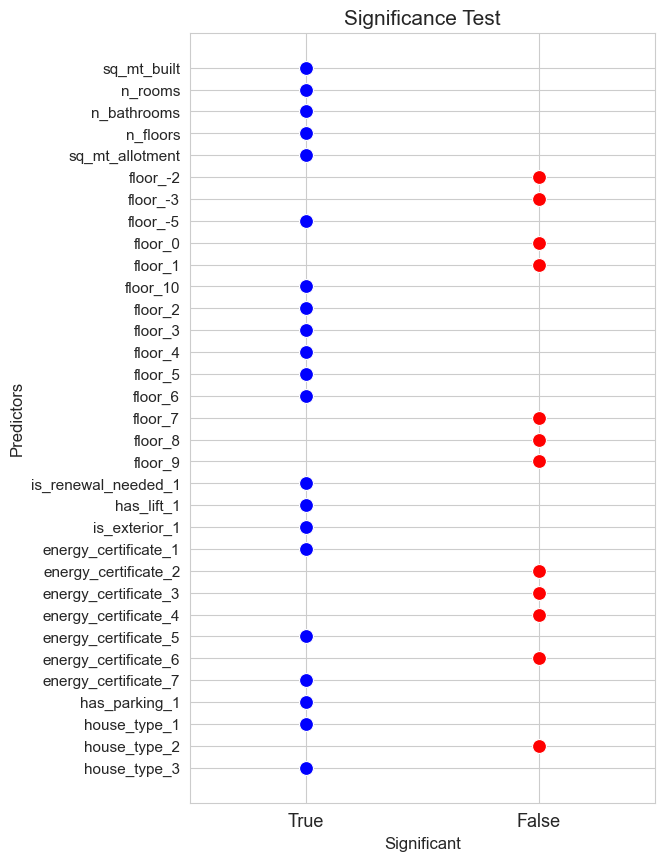

In [102]:
# Full model - dummies
significant_pred_model_dummies_ST, not_significant_pred_model_dummies_ST = significant_test(model=full_model_dummies, alpha=0.05, figsize=(6,10))

In [103]:
significant_pred_model_dummies_ST = recognition(significant_pred_model_dummies_ST)
not_significant = recognition(not_significant_pred_model_dummies_ST)
not_significant_pred_model_dummies_ST = np.array([x for x in not_significant if x not in significant_pred_model_dummies_ST]) 

predictors_selected['ST_dummies'] = significant_pred_model_dummies_ST
interactions_selected['ST_dummies'] = None
pred_to_dummies['ST_dummies'] = [x for x in cat_predictors if x in predictors_selected['ST_inter_dummies']]

In [104]:
predictors_selected['ST_dummies']

array(['sq_mt_allotment', 'sq_mt_built', 'n_floors', 'n_bathrooms',
       'floor', 'is_renewal_needed', 'is_exterior', 'energy_certificate',
       'house_type', 'has_parking', 'has_lift', 'n_rooms'], dtype='<U18')

In [105]:
interactions_selected['ST_dummies']

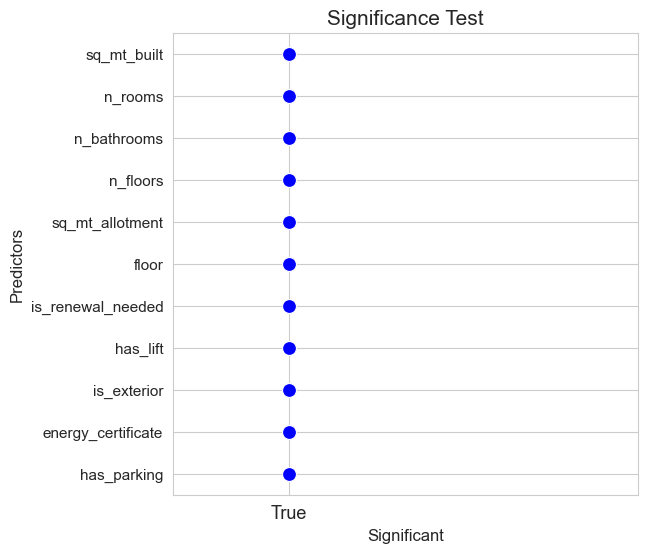

In [106]:
# Full model - not interactions - not dummies
significant_pred_model_basic_ST, not_significant_pred_model_basic_ST = significant_test(model=full_model_basic, alpha=0.05, figsize=(6,6))

In [107]:
predictors_selected['ST_basic'] = significant_pred_model_basic_ST
interactions_selected['ST_basic'] = None
pred_to_dummies['ST_basic'] = None

In [108]:
predictors_selected['ST_basic']

array(['sq_mt_built', 'n_rooms', 'n_bathrooms', 'n_floors',
       'sq_mt_allotment', 'floor', 'is_renewal_needed', 'has_lift',
       'is_exterior', 'energy_certificate', 'has_parking'], dtype=object)

#### **Likelihood Ratio Test**



**Deviance**

Given an statistical regression model $M$, such as Poisson regression model, its deviance is defined as:

$$D(M) = -2 \cdot log \left( \mathcal{L}(\widehat{\beta}_0, \widehat{\beta}) \right)$$

Where $\mathcal{L}(\widehat{\beta}_0, \widehat{\beta})$ is the estimated Likelihood function of the model.


The deviance is a measure of how well the model is fitting the training data, so, is a measure of **goodness of fit** of the model.

**Properties:**

- $D(M)\in [0, \infty)$

- The larger $D(M)$, the worse $M$ fits the training data.

- The smaller $D(M)$, the better $M$ fits the training data.

- The null model $M_0$ (the one that doesn't include predictors) has the maximum deviance.

- The classic determination coefficient $R$-square can be obtain through the deviance as $\hspace{0.05cm}R^2(M) = 1 - \dfrac{D(M)}{D(M_0)}$

**Likelihood Ratio Test as significance test**

Originally the Likelihood ratio test is a test to compare the goodness of fit of different nested models, but in this section we are going to adapt it to be a significance test for the predictors.

Given two nested models $M_p$, $M_{p-1}$ such that $M_p$ is the full model (includes the $p$ available predictors) and $M_{p-1}$ is the same model but without the predictor $X_j$.

The significant test for predictor $X_j$ can be perform as a Likelihood Ratio Test:


\begin{cases}
H_0 : M_{p-1}  \\
H_1 : M_p
\end{cases}


**Statistic:**

$$LTR = D(M_{p-1}) - D(M_p) \sim \chi_{1}^2$$

**p-value:**

$$pvalue = P(\chi_{1}^2 \geq LRT)$$

**Decision rule:**

- If $pvalue < \alpha \hspace{0.1cm} \Rightarrow\hspace{0.1cm}$ Reject $H_0 \hspace{0.1cm}\Rightarrow\hspace{0.1cm}$  $M_p$ fits better the training data than $M_{p-1}$    $\hspace{0.1cm}\Rightarrow\hspace{0.1cm}$ predictor $\mathcal{X}_j$  is **significative** to explain the response.

- If $pvalue \geq \alpha \hspace{0.1cm} \Rightarrow\hspace{0.1cm}$ Not Reject $H_0 \hspace{0.1cm}\Rightarrow\hspace{0.1cm}$  $M_{p-1}$ fits better the training data than $M_{p}$  $\hspace{0.1cm}\Rightarrow\hspace{0.1cm}$ predictor $\mathcal{X}_j$  is **not significative** to explain the response.

Let's implements the Likelihood Test Ratio as significance test in `Python`:

In [109]:
def LRT(full_model, predictor_to_test) :

    X_full = full_model.X
    Y = full_model.Y
    interactions = full_model.interactions_to_add
    pred_to_dummies = full_model.pred_to_dummies
    predictors = X_full.columns.tolist().copy()

    if predictor_to_test in predictors:
        predictors_reduced = [x for x in predictors if x != predictor_to_test]
        interactions_reduced = [(quant, cat) for (quant, cat) in interactions if cat != predictor_to_test and quant != predictor_to_test] if interactions is not None else None
        pred_to_dummies_reduced = [x for x in pred_to_dummies if x != predictor_to_test] if pred_to_dummies is not None else None

    elif predictor_to_test in interactions:
        predictors_reduced = predictors
        interactions_reduced = [(quant, cat) for (quant, cat) in interactions if (quant, cat) != predictor_to_test]
        pred_to_dummies_reduced = pred_to_dummies

    reduced_model = linear_model(Y=Y, X=X_full[predictors_reduced])
    reduced_model.fit(pred_to_dummies=pred_to_dummies_reduced, interactions_to_add=interactions_reduced)

    loglike_full = full_model.linear_fit.llf
    loglike_reduced = reduced_model.linear_fit.llf
    deviance_full = -2*loglike_full
    deviance_reduced = -2*loglike_reduced
    LRT_ = deviance_reduced - deviance_full
    df_full = full_model.linear_fit.df_model # number of coefficients of full model
    df_reduced = reduced_model.linear_fit.df_model # number of coefficients of reduced model 
    pvalue = stats.chi2.sf(LRT_, df_full-df_reduced)

    return pvalue

In [110]:
def LTR_significant_test(full_model, alpha=0.05, figsize=(7,7)) :

    if full_model.interactions_to_add is not None :
        predictors_to_test =  full_model.X.columns.tolist() + full_model.interactions_to_add 
    else:
        predictors_to_test =  full_model.X.columns.tolist()
    
    pvalue = dict()

    for predictor in predictors_to_test :
        pvalue[predictor] = LRT(full_model, predictor_to_test=predictor)
    
    predictors_tested = np.array([str(x) for x in pvalue.keys()])
    pvalues = np.array([x for x in pvalue.values()])
    significance_results = pvalues < alpha
    significant_predictors = predictors_tested[significance_results==True]
    not_significant_predictors = predictors_tested[significance_results==False]
    significance_test_results_str = np.array([str(x) for x in significance_results])

    plt.figure(figsize=figsize)
    ax = sns.scatterplot(x=significance_test_results_str, y=predictors_tested, color='red', s=100)
    ax = sns.scatterplot(x=significance_test_results_str[significance_results==True], 
                         y=predictors_tested[significance_results==True], color='blue', s=100)

    plt.title('Significance Test - LRT', size=15)
    ax.set_ylabel('Predictors', size=12)
    ax.set_xlabel('Significant', size=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    ax.set_xlim(-0.5, 1.5) 
    plt.show()

    return significant_predictors, not_significant_predictors

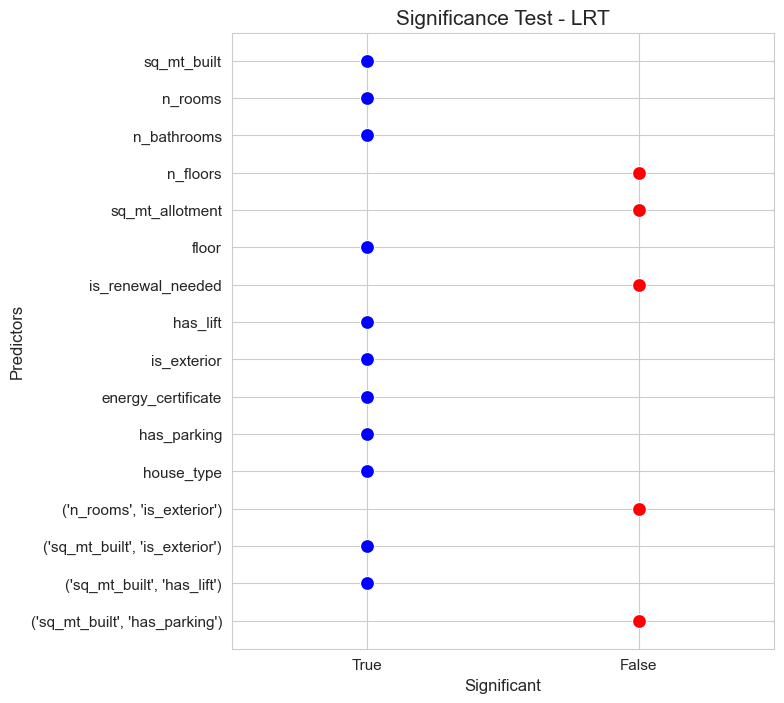

In [111]:
# Full model LRT - interactions - dummies
significant_pred_model_inter_dummies_LRT, not_significant_pred_model_inter_dummies_LRT = LTR_significant_test(full_model=full_model_inter_dummies, 
                                                                                                              alpha=0.05, figsize=(7,8))

In [112]:
significant_pred_model_inter_dummies_LRT

array(['sq_mt_built', 'n_rooms', 'n_bathrooms', 'floor', 'has_lift',
       'is_exterior', 'energy_certificate', 'has_parking', 'house_type',
       "('sq_mt_built', 'is_exterior')", "('sq_mt_built', 'has_lift')"],
      dtype='<U30')

In [113]:
not_significant_pred_model_inter_dummies_LRT

array(['n_floors', 'sq_mt_allotment', 'is_renewal_needed',
       "('n_rooms', 'is_exterior')", "('sq_mt_built', 'has_parking')"],
      dtype='<U30')

In [114]:
predictors_selected['LRT_inter_dummies'] = [x for x in significant_pred_model_inter_dummies_LRT if not x[0] == '(']
interactions_selected['LRT_inter_dummies'] = [ast.literal_eval(x) for x in significant_pred_model_inter_dummies_LRT if x[0] == '(']
pred_to_dummies['LRT_inter_dummies'] = [x for x in cat_predictors if x in predictors_selected['LRT_inter_dummies']]

In [115]:
predictors_selected['LRT_inter_dummies'] 

['sq_mt_built',
 'n_rooms',
 'n_bathrooms',
 'floor',
 'has_lift',
 'is_exterior',
 'energy_certificate',
 'has_parking',
 'house_type']

In [116]:
interactions_selected['LRT_inter_dummies']

[('sq_mt_built', 'is_exterior'), ('sq_mt_built', 'has_lift')]

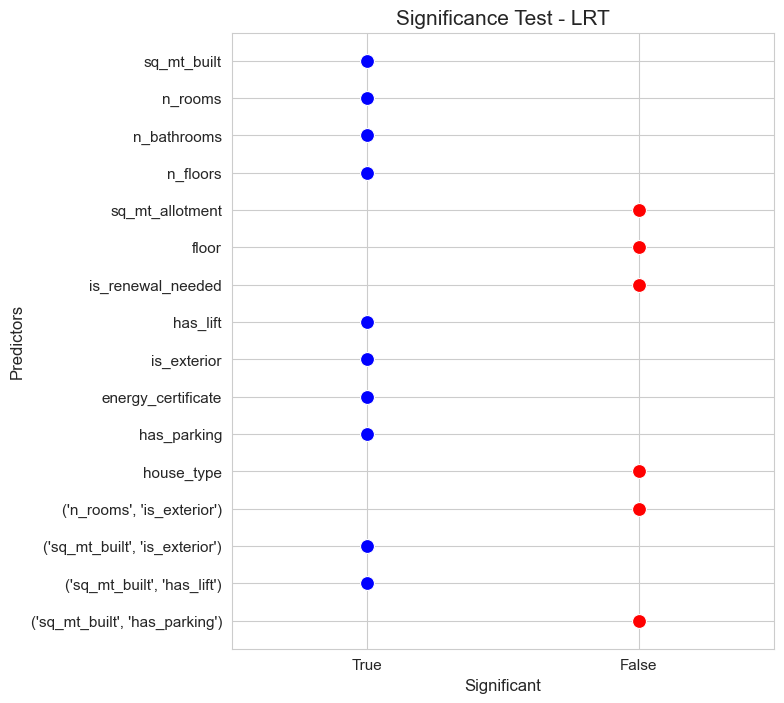

In [117]:
# Full model - interactions 
significant_pred_model_inter_LRT, not_significant_pred_model_inter_LRT = LTR_significant_test(full_model=full_model_inter, alpha=0.05, figsize=(7,8))

In [118]:
predictors_selected['LRT_inter'] = [x for x in significant_pred_model_inter_LRT if not x[0] == '(']
interactions_selected['LRT_inter'] = [ast.literal_eval(x) for x in significant_pred_model_inter_LRT if x[0] == '(']
pred_to_dummies['LRT_inter'] = None

In [119]:
predictors_selected['LRT_inter']

['sq_mt_built',
 'n_rooms',
 'n_bathrooms',
 'n_floors',
 'has_lift',
 'is_exterior',
 'energy_certificate',
 'has_parking']

In [120]:
interactions_selected['LRT_inter']

[('sq_mt_built', 'is_exterior'), ('sq_mt_built', 'has_lift')]

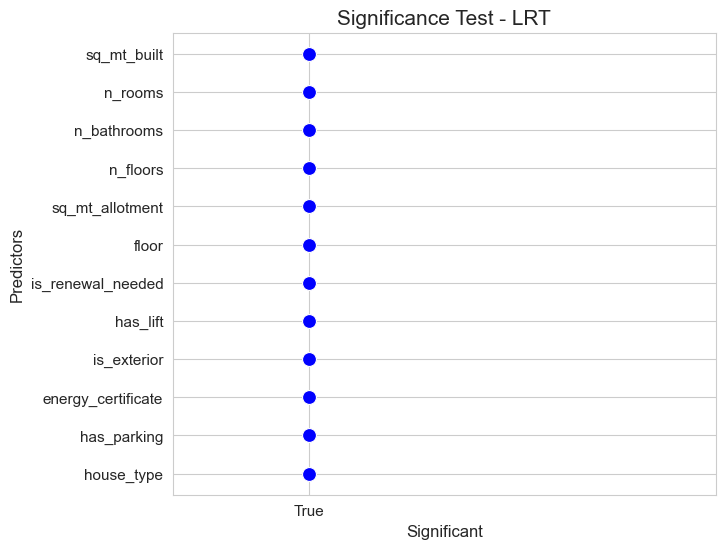

In [121]:
# Full model - dummies
significant_pred_model_dummies_LRT, not_significant_pred_model_dummies_LRT = LTR_significant_test(full_model=full_model_dummies, 
                                                                                                  alpha=0.05, figsize=(7,6))

In [122]:
predictors_selected['LRT_dummies'] = significant_pred_model_dummies_LRT
interactions_selected['LRT_dummies'] = None
pred_to_dummies['LRT_dummies'] = None

In [123]:
predictors_selected['LRT_dummies']

array(['sq_mt_built', 'n_rooms', 'n_bathrooms', 'n_floors',
       'sq_mt_allotment', 'floor', 'is_renewal_needed', 'has_lift',
       'is_exterior', 'energy_certificate', 'has_parking', 'house_type'],
      dtype='<U18')

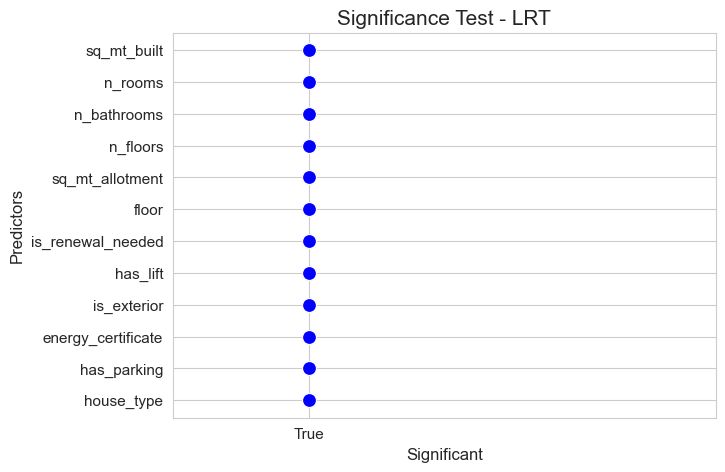

In [124]:
# Full model - basic (not interactions - not dummies)
significant_pred_model_basic_LRT, not_significant_pred_model_basic_LRT = LTR_significant_test(full_model=full_model_basic, 
                                                                                              alpha=0.05, figsize=(7,5))

In [125]:
predictors_selected['LRT_basic'] = significant_pred_model_basic_LRT
interactions_selected['LRT_basic'] = None
pred_to_dummies['LRT_basic'] = None

In [126]:
predictors_selected['LRT_basic']

array(['sq_mt_built', 'n_rooms', 'n_bathrooms', 'n_floors',
       'sq_mt_allotment', 'floor', 'is_renewal_needed', 'has_lift',
       'is_exterior', 'energy_certificate', 'has_parking', 'house_type'],
      dtype='<U18')

#### **Predictors selection based on predictive performance**


The idea is to consider the predictors as hyper-parameters of the model and optimize them using algorithms like grid search and cross validation.

##### **Train-Train - Train-Validate split**

Since we need to test the predictive performance of the models we need to split train partition in train-train (train2) to train the models and train-validate (val) to test them.

We don't use test partition in this case since this task implies taking decisions regarding the predictive modeling process and these decisions should be done with the training data, otherwise this can lead to **data leakage**.

The test partition will only be  used to estimate the future performance of our final model.

##### **Best subset selection algorithm**

Best subset selection algorithm :

We have $p$ predictors.

  
- We train all the possible linear models with  $1$ predictor, and select the one with less test prediction error computed by simple validation $\Rightarrow M_1^*$

- We train all the possible linear models with  $2$ predictor, and select the one with less test prediction error computed by simple validation $\Rightarrow M_2^*$  
   $\dots$ 

- We train all the possible linear models with  $p-1$ predictor, and select the one with less test prediction error computed by simple validation $\Rightarrow M_{p-1}^*$

- We train the full linear model $\Rightarrow M_{p}$

Among $M_1^*, M_2^*,\dots, M_{p-1}^*, M_p$ we select the one with less test prediction error, and it is consider the best Poisson model according to best subset selection algorithm.


This method is feasible in this case, because as we saw before, the number of possible linear regression models that can be trained with all the possible subsets of the $p=12$ predictors is $4095$, which is acceptable computationally with the `statsmodels` implementation of the linear regression model. 



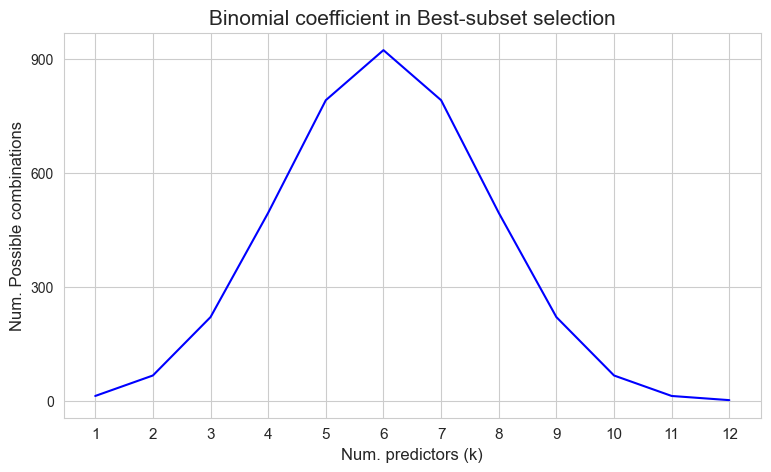

In [127]:
p=len(predictors)
binom_values = [binom(p=len(predictors), k=k) for k in np.arange(1,p+1)]

plt.figure(figsize=(9, 5))
ax = sns.lineplot(y=binom_values, x=np.arange(1,p+1), color='blue')
ax.set_ylabel('Num. Possible combinations', size=12)
ax.set_xlabel('Num. predictors (k)', size=12)
plt.xticks(np.arange(1,p+1), fontsize=11)
plt.yticks(np.arange(0,1000, 300))
plt.title('Binomial coefficient in Best-subset selection', size=15)
plt.show()

In [128]:
def simple_validation(X, Y, train_size, seed, pred_to_dummies, interactions_to_add):

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_size, random_state=seed)

    model = linear_model(Y=Y_train, X=X_train)
    model.fit(pred_to_dummies=pred_to_dummies, interactions_to_add=interactions_to_add)
    Y_test_hat = model.predict(X_test)
    RMSE = np.sqrt(np.mean((Y_test - Y_test_hat)**2))

    return RMSE

In [129]:
def best_subset_selection(X, Y, pred_to_dummies=None, interactions=None, train_size=0.75, seed=123) :
    
    results = dict()
    RMSE = dict()
    predictors = X_train.columns.tolist()
    n_iter = len(predictors)

    for iter in range(1, n_iter+1) :

        predictors_combinations = []
        predictors_combinations = list(combinations(predictors, iter))

        for predictors_combi in predictors_combinations:
 
            pred_to_dummies_reduced = [x for x in pred_to_dummies if x in list(predictors_combi)] if pred_to_dummies is not None else None
            interactions_reduced = [(quant, cat) for (quant, cat) in interactions if cat in list(predictors_combi) and quant in list(predictors_combi)] if interactions is not None else None
            RMSE[predictors_combi] = simple_validation(X=X[list(predictors_combi)], Y=Y, train_size=train_size, seed=seed,
                                                       pred_to_dummies=pred_to_dummies_reduced, interactions_to_add=interactions_reduced)

        RMSE_predictors = [x for x in RMSE.keys()]
        RMSE_values = np.array([x for x in RMSE.values()])
        best_predictors = RMSE_predictors[np.argsort(RMSE_values)[0]]
        best_interactions = tuple([(quant,cat) for (quant,cat) in interactions if quant in list(best_predictors) and cat in list(best_predictors)]) if interactions is not None else None
        if best_interactions is not None:
            results[best_predictors + best_interactions] = np.min(RMSE_values) 
        else:
            results[best_predictors] = np.min(RMSE_values) 
        # Clean the dictionary
        RMSE = dict()

    return results

In [130]:
# Models with: dummies - interactions
results = best_subset_selection(X=X_train, Y=Y_train, train_size=0.75, seed=123, 
                                pred_to_dummies=cat_predictors, 
                                interactions=[('n_rooms', 'is_exterior'), ('sq_mt_built', 'is_exterior'), ('sq_mt_built', 'has_lift'), ('sq_mt_built', 'has_parking')]) 

In [131]:
result_predictors = [x for x in results.keys()]
result_predictors_str = np.array([str(x) for x in results.keys()])
result_score = np.array([x for x in results.values()])
best_pred_bestsubset_inter_dummies_str = result_predictors_str[np.argsort(result_score)[0]]
best_pred_bestsubset_inter_dummies = list(result_predictors[np.argsort(result_score)[0]])
best_RMSE_bestsubset_inter_dummies = np.min(result_score)

predictors_selected['BestSubset_inter_dummies'] = [x for x in best_pred_bestsubset_inter_dummies if not isinstance(x,tuple)]
interactions_selected['BestSubset_inter_dummies'] = [ast.literal_eval(x) for x in best_pred_bestsubset_inter_dummies if isinstance(x,tuple)]
pred_to_dummies['BestSubset_inter_dummies'] = [x for x in cat_predictors if x in predictors_selected['BestSubset_inter_dummies']]

In [132]:
predictors_selected['BestSubset_inter_dummies'] 

['is_renewal_needed', 'has_lift', 'is_exterior']

In [133]:
interactions_selected['BestSubset_inter_dummies']

[]

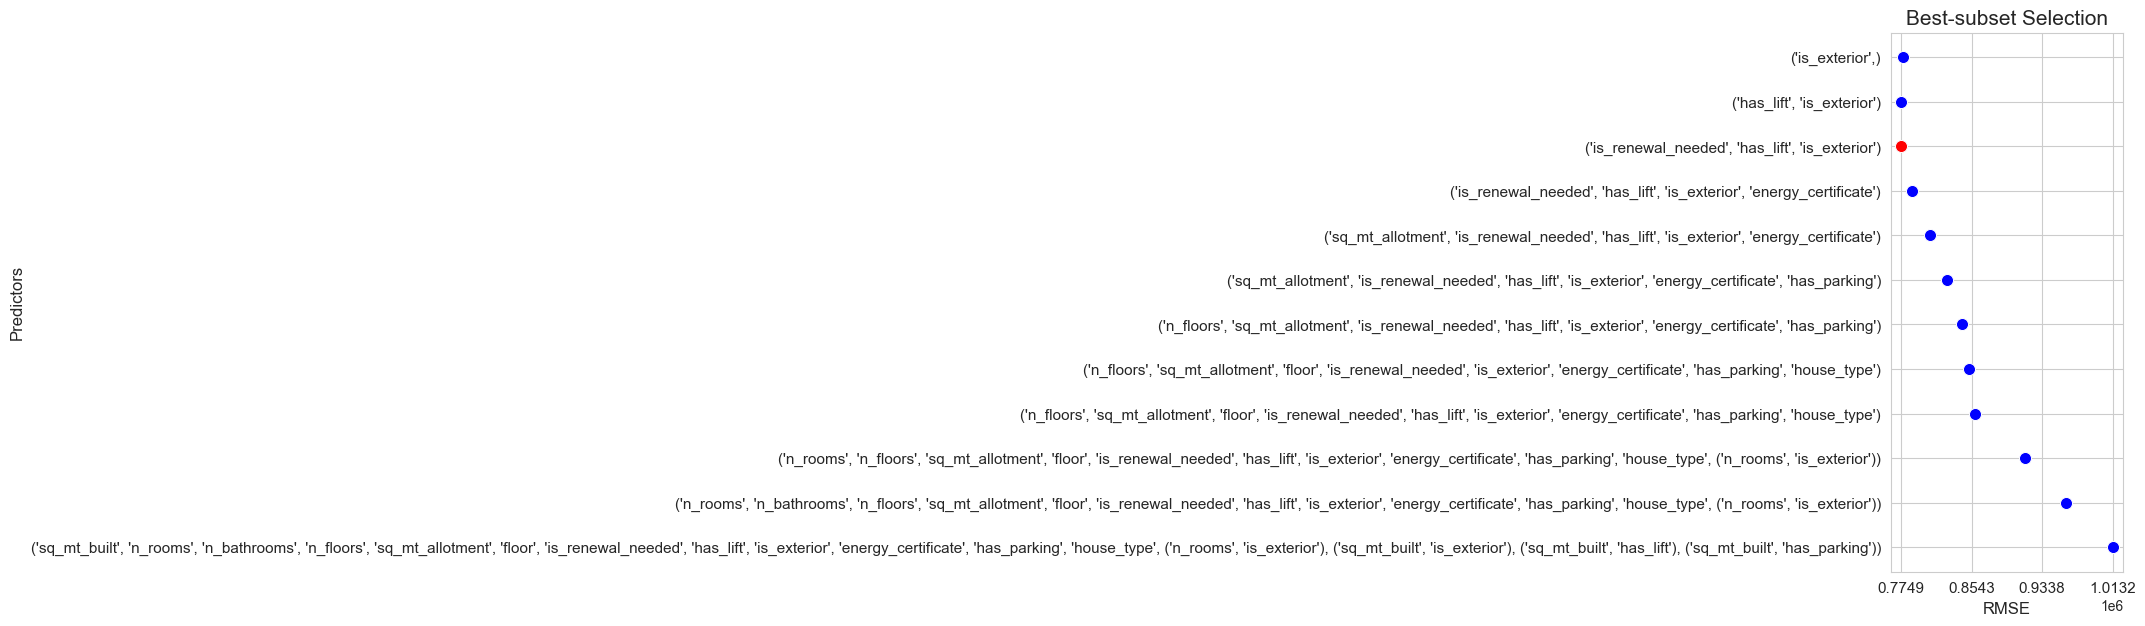

In [134]:
plt.figure(figsize=(3, 7))
ax = sns.scatterplot(x=result_score, y=result_predictors_str, color='blue', s=75)
ax = sns.scatterplot(x=best_RMSE_bestsubset_inter_dummies, y=[best_pred_bestsubset_inter_dummies_str], color='red', s=75)
plt.title('Best-subset Selection', size=15)
ax.set_ylabel('Predictors', size=12)
ax.set_xlabel('RMSE', size=12)
min = np.min(result_score)
max = np.max(result_score)
plt.xticks(np.round(np.linspace(min,max, 4), 2), fontsize=11)
plt.yticks(fontsize=11)
plt.show()

In [135]:
# Models with: dummies
results = best_subset_selection(X=X_train, Y=Y_train, train_size=0.75, seed=123, 
                                pred_to_dummies=cat_predictors, 
                                interactions=None) 

In [136]:
result_predictors = [x for x in results.keys()]
result_predictors_str = np.array([str(x) for x in results.keys()])
result_score = np.array([x for x in results.values()])
best_pred_bestsubset_dummies_str = result_predictors_str[np.argsort(result_score)[0]]
best_pred_bestsubset_dummies = list(result_predictors[np.argsort(result_score)[0]])
best_RMSE_bestsubset_dummies = np.min(result_score)

predictors_selected['BestSubset_dummies'] = best_pred_bestsubset_dummies
interactions_selected['BestSubset_dummies'] = None
pred_to_dummies['BestSubset_dummies'] = [x for x in cat_predictors if x in predictors_selected['BestSubset_dummies']]

In [137]:
predictors_selected['BestSubset_dummies']

['is_renewal_needed', 'has_lift', 'is_exterior']

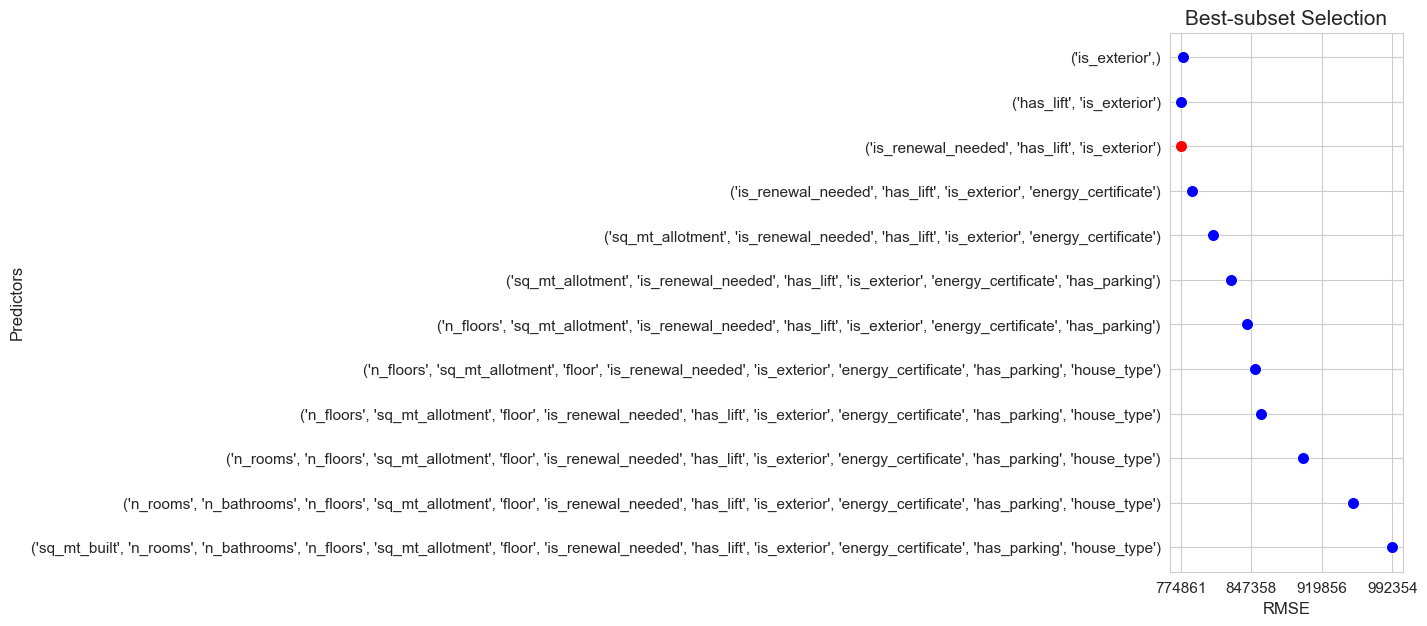

In [138]:
plt.figure(figsize=(3, 7))
ax = sns.scatterplot(x=result_score, y=result_predictors_str, color='blue', s=75)
ax = sns.scatterplot(x=best_RMSE_bestsubset_dummies, y=[best_pred_bestsubset_dummies_str], color='red', s=75)
plt.title('Best-subset Selection', size=15)
ax.set_ylabel('Predictors', size=12)
ax.set_xlabel('RMSE', size=12)
min = np.min(result_score)
max = np.max(result_score)
plt.xticks(np.round(np.linspace(min,max, 4), 2), fontsize=11)
plt.yticks(fontsize=11)
plt.show()

In [139]:
# Models with: interactions
results = best_subset_selection(X=X_train, Y=Y_train, train_size=0.75, seed=123, 
                      pred_to_dummies=None, 
                      interactions=[('n_rooms', 'is_exterior'), ('sq_mt_built', 'is_exterior'), ('sq_mt_built', 'has_lift'), ('sq_mt_built', 'has_parking')]) 

In [140]:
result_predictors = [x for x in results.keys()]
result_predictors_str = np.array([str(x) for x in results.keys()])
result_score = np.array([x for x in results.values()])
best_pred_bestsubset_inter_str = result_predictors_str[np.argsort(result_score)[0]]
best_pred_bestsubset_inter = list(result_predictors[np.argsort(result_score)[0]])
best_RMSE_bestsubset_inter = np.min(result_score)

predictors_selected['BestSubset_inter'] = [x for x in best_pred_bestsubset_inter if not isinstance(x, tuple)]
interactions_selected['BestSubset_inter'] = [x for x in best_pred_bestsubset_inter if isinstance(x, tuple)]
pred_to_dummies['BestSubset_inter'] = None

In [141]:
predictors_selected['BestSubset_inter']

['sq_mt_built',
 'n_rooms',
 'n_bathrooms',
 'n_floors',
 'has_lift',
 'is_exterior',
 'energy_certificate',
 'house_type']

In [142]:
interactions_selected['BestSubset_inter']

[('n_rooms', 'is_exterior'),
 ('sq_mt_built', 'is_exterior'),
 ('sq_mt_built', 'has_lift')]

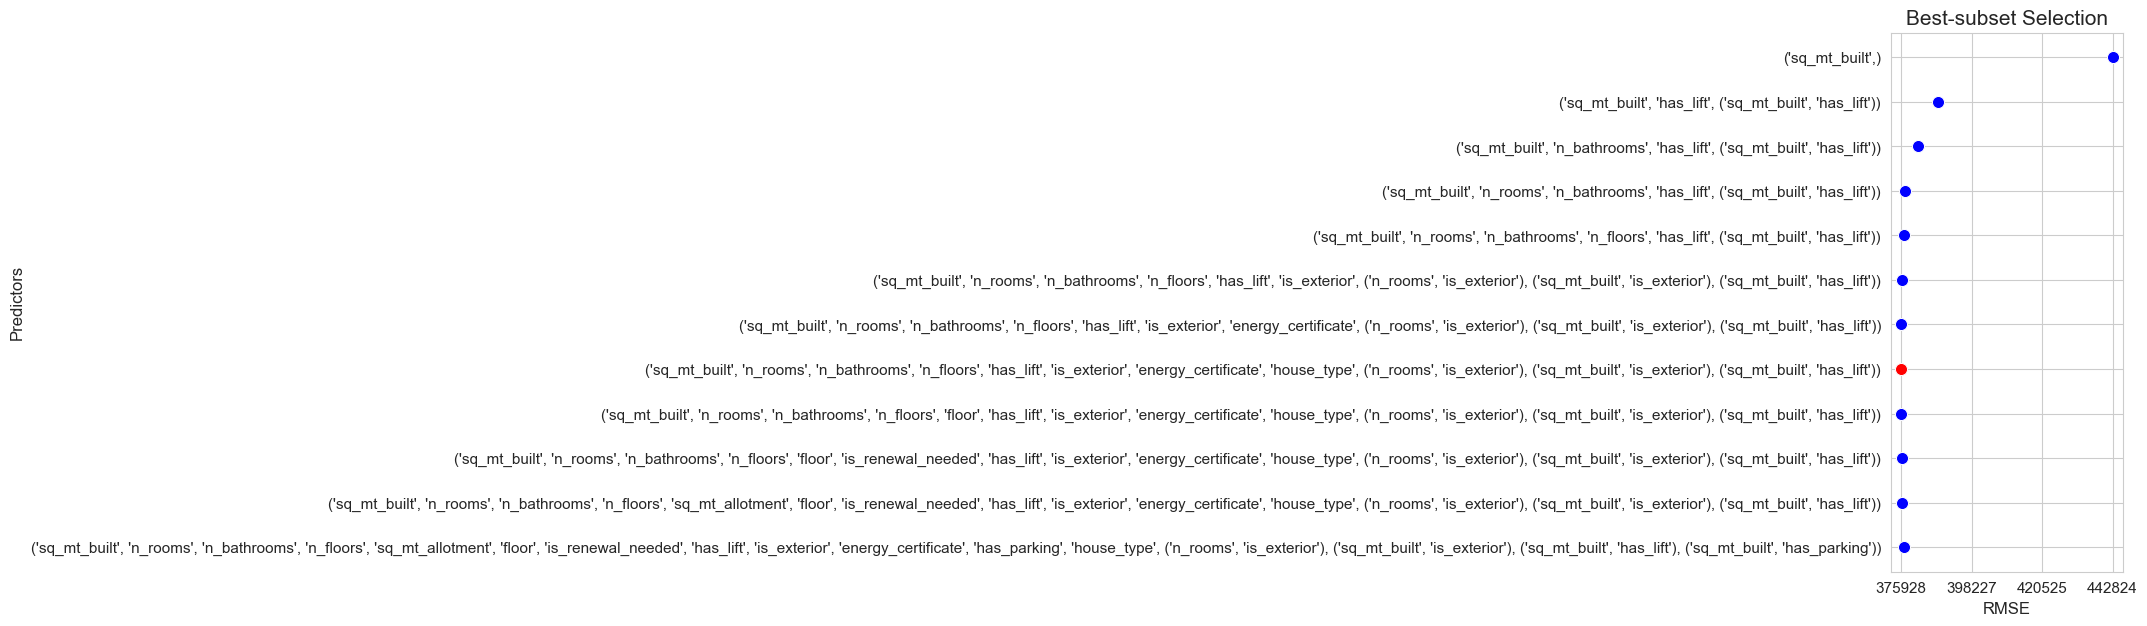

In [143]:
plt.figure(figsize=(3, 7))
ax = sns.scatterplot(x=result_score, y=result_predictors_str, color='blue', s=75)
ax = sns.scatterplot(x=best_RMSE_bestsubset_inter, y=[best_pred_bestsubset_inter_str], color='red', s=75)
plt.title('Best-subset Selection', size=15)
ax.set_ylabel('Predictors', size=12)
ax.set_xlabel('RMSE', size=12)
min = np.min(result_score)
max = np.max(result_score)
plt.xticks(np.round(np.linspace(min,max, 4), 2), fontsize=11)
plt.yticks(fontsize=11)
plt.show()

In [144]:
# basic (not inter - not dummies)

results = best_subset_selection(X=X_train, Y=Y_train, train_size=0.75, seed=123, 
                      pred_to_dummies=None, 
                      interactions=None) 

In [145]:
result_predictors = [x for x in results.keys()]
result_predictors_str = np.array([str(x) for x in results.keys()])
result_score = np.array([x for x in results.values()])
best_pred_bestsubset_basic_str = result_predictors_str[np.argsort(result_score)[0]]
best_pred_bestsubset_basic = list(result_predictors[np.argsort(result_score)[0]])
best_RMSE_bestsubset_basic = np.min(result_score)

predictors_selected['BestSubset_basic'] = best_pred_bestsubset_basic 
interactions_selected['BestSubset_basic'] = None
pred_to_dummies['BestSubset_basic'] = None

In [146]:
predictors_selected['BestSubset_basic'] 

['sq_mt_built',
 'n_rooms',
 'n_bathrooms',
 'n_floors',
 'sq_mt_allotment',
 'floor',
 'has_lift',
 'is_exterior',
 'energy_certificate',
 'has_parking']

In [147]:
interactions_selected['BestSubset_basic']

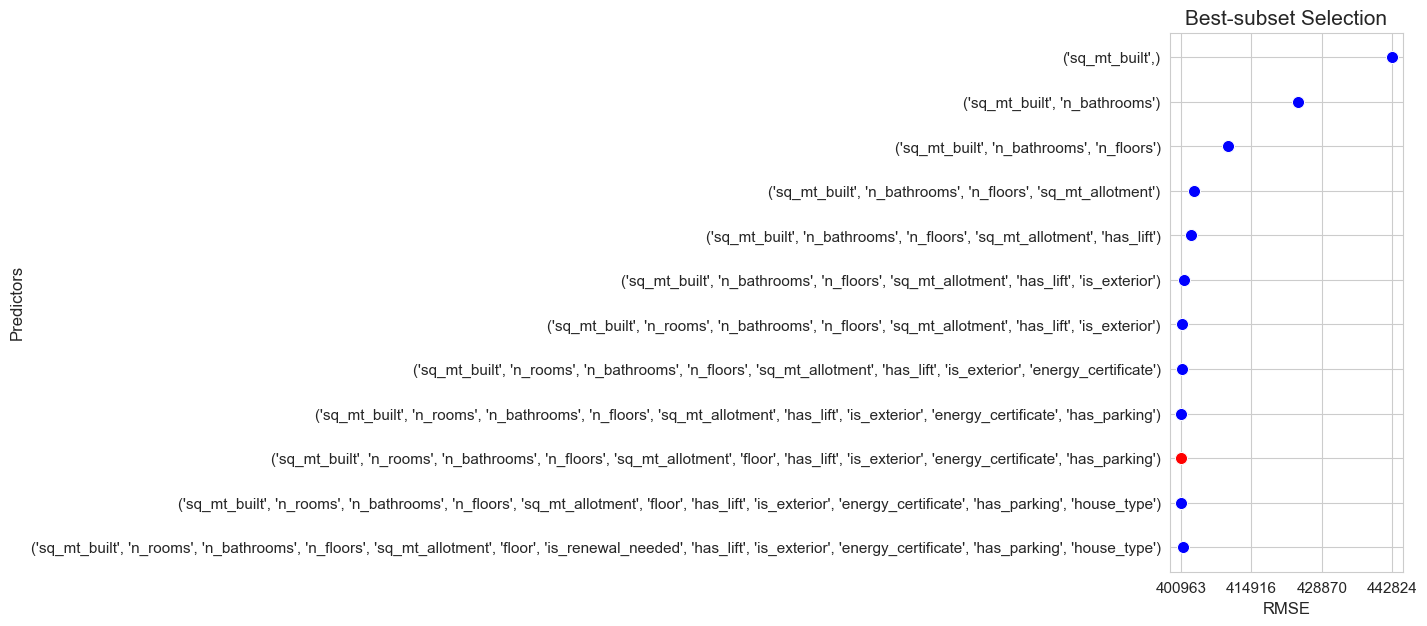

In [148]:
plt.figure(figsize=(3, 7))
ax = sns.scatterplot(x=result_score, y=result_predictors_str, color='blue', s=75)
ax = sns.scatterplot(x=best_RMSE_bestsubset_basic, y=[best_pred_bestsubset_basic_str], color='red', s=75)
plt.title('Best-subset Selection', size=15)
ax.set_ylabel('Predictors', size=12)
ax.set_xlabel('RMSE', size=12)
min = np.min(result_score)
max = np.max(result_score)
plt.xticks(np.round(np.linspace(min,max, 4), 2), fontsize=11)
plt.yticks(fontsize=11)
plt.show()

Backward and forward are not necessary in this case since we have been able to perform best-subset, that explore all the possible combinations of predictors (included the ones explore with backward and forward).

### **Model selection**

Since we we want to compare different models based on their predictive performance we need to use train-train (train2) to train them and train-validate (val) to test them, so that we will be able to compare their "real" predictive performance and choose the best one.

We don't use test partition in model selection because it is part of training, since implies taking decisions regarding the predictive modeling process and this can lead to **data leakage**.

The test partition will only be  used  to estimate the future performance of our final model.

In [149]:
def repeated_simple_validation(X, Y, train_size, n_repetitions, seed, pred_to_dummies, interactions_to_add):

    np.random.seed(seed)
    seed_arr = np.random.randint(1, 9999999, n_repetitions)
    RMSE_list = []

    for iter in range(0, n_repetitions) :
        
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_size, random_state=seed_arr[iter])
        model = linear_model(Y=Y_train, X=X_train)
        model.fit(pred_to_dummies=pred_to_dummies, interactions_to_add=interactions_to_add)
        try: # If X_test contains categorical variable without some categories that are present in X_train, an error will occur.
            Y_test_hat = model.predict(X_test)
            RMSE_list.append(np.sqrt(np.mean((Y_test - Y_test_hat)**2)))
        except: 
            continue

    RMSE = np.mean(RMSE_list)
    return RMSE

In [150]:
def kfold_cv(X, Y, n_folds, shuffle, seed, pred_to_dummies, interactions_to_add, ):

    
    kfold = KFold(n_splits=n_folds, shuffle=shuffle, random_state=seed)
    folds = list(kfold.split(X=X, y=Y))
    RMSE_list = []

    for iter in range(0, n_folds) :

        X_train = X.iloc[folds[iter][0], :] ; X_test = X.iloc[folds[iter][1], :]
        Y_train = Y.iloc[folds[iter][0]] ; Y_test = Y.iloc[folds[iter][1]]
        model = linear_model(Y=Y_train, X=X_train)
        model.fit(pred_to_dummies=pred_to_dummies, interactions_to_add=interactions_to_add)
        try: # If X_test contains categorical variable without some categories that are present in X_train, an error will occur.
            Y_test_hat = model.predict(X_test)
            RMSE_list.append(np.sqrt(np.mean((Y_test - Y_test_hat)**2)))
        except: 
            continue

    RMSE = np.mean(RMSE_list)
    return RMSE

In [151]:
RMSE_rep_sv, RMSE_kfold = {}, {}

for x in predictors_selected.keys() :

    print(x)

    RMSE_rep_sv[x] = repeated_simple_validation(X=X_train[predictors_selected[x]], Y=Y_train, n_repetitions=100,
                                                                 train_size=0.75, seed=123, 
                                                                 pred_to_dummies=pred_to_dummies[x], 
                                                                 interactions_to_add=interactions_selected[x])

    RMSE_kfold[x] = kfold_cv(X=X_train[predictors_selected[x]], Y=Y_train, n_folds=5,
                                              shuffle=True, seed=123, 
                                              pred_to_dummies=pred_to_dummies[x], 
                                              interactions_to_add=interactions_selected[x])

ST_inter_dummies


ST_inter
ST_dummies
ST_basic
LRT_inter_dummies
LRT_inter
LRT_dummies
LRT_basic
BestSubset_inter_dummies
BestSubset_dummies
BestSubset_inter
BestSubset_basic


In [152]:
RMSE_rep_sv_arr = np.array([x for x in RMSE_rep_sv.values()])
RMSE_kfold_arr = np.array([x for x in RMSE_kfold.values()])
Models_arr = np.array(['Linear_' + x for x in RMSE_rep_sv.keys()])

Best_Model_rep_sv = Models_arr[np.argsort(RMSE_rep_sv_arr)[0]]
RMSE_Best_Model_rep_sv = np.min(RMSE_rep_sv_arr)

Best_Model_kfold = Models_arr[np.argsort(RMSE_kfold_arr)[0]]
RMSE_Best_Model_kfold = np.min(RMSE_kfold_arr)

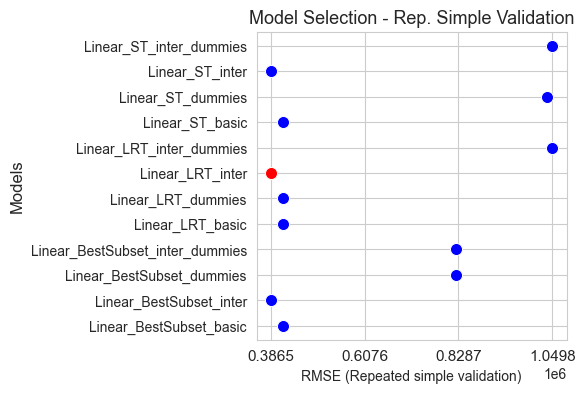

In [153]:
plt.figure(figsize=(4, 4))
ax = sns.scatterplot(x=RMSE_rep_sv_arr, y=Models_arr, color='blue', s=75)
ax = sns.scatterplot(x=RMSE_Best_Model_rep_sv, y=[Best_Model_rep_sv], color='red', s=75)
plt.title('Model Selection - Rep. Simple Validation', size=13)
ax.set_ylabel('Models', size=12)
ax.set_xlabel('RMSE (Repeated simple validation)', size=10)
min = np.min(RMSE_rep_sv_arr)
max = np.max(RMSE_rep_sv_arr)
plt.xticks(np.round(np.linspace(min,max, 4), 3), fontsize=11)
plt.yticks(fontsize=10)
plt.show()

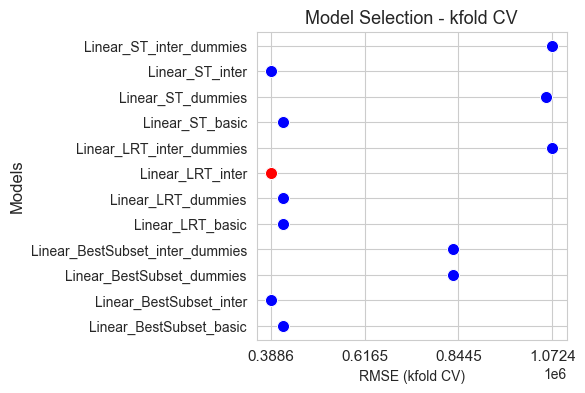

In [154]:
plt.figure(figsize=(4, 4))
ax = sns.scatterplot(x=RMSE_kfold_arr, y=Models_arr, color='blue', s=75)
ax = sns.scatterplot(x=RMSE_Best_Model_kfold, y=[Best_Model_kfold], color='red', s=75)
plt.title('Model Selection - kfold CV', size=13)
ax.set_ylabel('Models', size=12)
ax.set_xlabel('RMSE (kfold CV)', size=10)
min = np.min(RMSE_kfold_arr)
max = np.max(RMSE_kfold_arr)
plt.xticks(np.round(np.linspace(min,max, 4), 3), fontsize=11)
plt.yticks(fontsize=10)
plt.show()

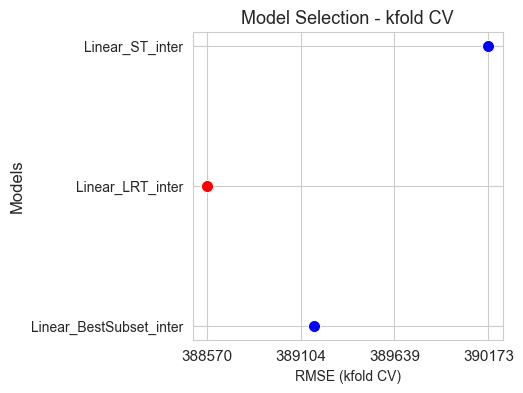

In [155]:
plt.figure(figsize=(4, 4))
ax = sns.scatterplot(x=RMSE_kfold_arr[RMSE_kfold_arr < 400000], y=Models_arr[RMSE_kfold_arr < 400000], color='blue', s=75)
ax = sns.scatterplot(x=RMSE_Best_Model_kfold, y=[Best_Model_kfold], color='red', s=75)
plt.title('Model Selection - kfold CV', size=13)
ax.set_ylabel('Models', size=12)
ax.set_xlabel('RMSE (kfold CV)', size=10)
min = np.min(RMSE_kfold_arr[RMSE_kfold_arr < 400000])
max = np.max(RMSE_kfold_arr[RMSE_kfold_arr < 400000])
plt.xticks(np.round(np.linspace(min,max, 4), 3), fontsize=11)
plt.yticks(fontsize=10)
plt.show()

In [156]:
Best_Model_rep_sv

'Linear_LRT_inter'

In [157]:
RMSE_Best_Model_rep_sv

386539.9511010434

In [158]:
Best_Model_kfold

'Linear_LRT_inter'

In [159]:
RMSE_Best_Model_kfold

388569.913637558

In [160]:
predictors_selected['LRT_inter']

['sq_mt_built',
 'n_rooms',
 'n_bathrooms',
 'n_floors',
 'has_lift',
 'is_exterior',
 'energy_certificate',
 'has_parking']

In [161]:
interactions_selected['LRT_inter']

[('sq_mt_built', 'is_exterior'), ('sq_mt_built', 'has_lift')]

### **Estimation of future performance**

In this section we are going to estimate the future predictive performance of the best model (the one selected in the precious section). 
To estimate the future performance of the model we will use the training partition to train the model and the testing to make predictions an estimate the error, i.e, its future performance.

In [162]:
# Statsmodels doesn't work with Polars but Pandas.
X_test = X_test.to_pandas()

In [163]:
best_model = linear_model(Y=Y_train, X=X_train[predictors_selected['LRT_inter']])
best_model.fit(pred_to_dummies=None, interactions_to_add=interactions_selected['LRT_inter'])
Y_test_hat = best_model.predict(X_test[predictors_selected['LRT_inter']])
RMSE_future_performance = np.sqrt(np.mean((Y_test.to_numpy() - Y_test_hat)**2))

In [164]:
RMSE_future_performance

423290.67658042104

###  **Prediction intervals**

We have the following property:

$$
y_i \hspace{0.1cm} \sim \hspace{0.1cm} N \left(  \beta_0 + x_i^\prime \cdot \beta \hspace{0.05cm},\hspace{0.1cm} \sigma^2   \right)
$$

$$
\widehat{y}_i = \beta_0 + x_i^\prime \cdot \widehat{\beta} \hspace{0.1cm} \sim \hspace{0.1cm} N \left(  \beta_0 + x_i^\prime \cdot \beta \hspace{0.05cm},\hspace{0.1cm} \sigma^2 \cdot v_{i}  \right)
$$
 

   where:  

  - $v_{i} \hspace{0.05cm}=\hspace{0.05cm} x_i^\prime \cdot (X^\prime \cdot X)^{-1} \cdot x_i$

Therefore, we have the following:

$$
y_i - \hat{y}_i \hspace{0.1cm} \sim \hspace{0.1cm} N(0 \hspace{0.05cm},\hspace{0.12cm} \sigma^2 \cdot (1 + v_{i}))
$$


where:

- $E[y_i - \hat{y}_i] = 0$

- $Var(y_i - \hat{y}_i) = \sigma^2 \cdot (1 + v_{i})$

Then, we have the following pivotal quantity, with which we are going to build the prediction interval for a  significance level of $1-\alpha$:


$$
\dfrac{ ( y_i - \hat{y}_i ) - E[y_i - \hat{y}_i]}{\widehat{s_d}(y_i - \hat{y}_i ) } \hspace{0.1cm} =\hspace{0.1cm}  \dfrac{y_i - \hat{y}_i }{\sqrt{\widehat{\sigma}^2 \cdot (1 +  v_{i} ) }} \hspace{0.1cm} \sim \hspace{0.1cm} t_{n-p-1}
$$



Finally, we get the prediction (probability) interval:

$$
PI\left( \hspace{0.02cm} y_i \hspace{0.02cm} \right)_{1-\alpha}\hspace{0.1cm} =\hspace{0.1cm} \left[\hspace{0.15cm} \hat{y}_i  \hspace{0.15cm}\pm\hspace{0.15cm} t_{\alpha/2}^{n-p-1} \cdot \sqrt{ \widehat{\sigma}^2 \cdot (1 + v_{i} ) } \hspace{0.15cm} \right]
$$

 
**Observation:**

In the last interval the  $y_i$ term is a random variable and not a parameter, so, we cannot talk about confidence interval for $y_i$. This is the reason why we call it probability interval, because, as $y_i$ is a random variable, it makes sense to talk about that the probability of $y_i$ belonging to the $PI\left( \hspace{0.02cm} y_i \hspace{0.02cm} \right)_{1-\alpha}$ interval is $1-\alpha$.  


In [165]:
def prediction_intervals(X, Y, pred_to_dummies, interactions_to_add, alpha=0.05, train_size=0.70, seed=123, subset_len=70, figsize=(12,7)):

    if isinstance(X, pl.DataFrame):
        X = X.to_pandas()
    if isinstance(Y, (pl.DataFrame, pl.Series)):
        Y = Y.to_pandas()

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_size, random_state=seed)

    n = len(X_test)
    p = X_test.shape[1]
    t_alpha_2 = scipy.stats.t.isf(q=alpha/2, df=n-p-1, loc=0, scale=1)

    model = linear_model(Y=Y_train, X=X_train)
    model.fit(pred_to_dummies=pred_to_dummies, interactions_to_add=interactions_to_add)
    Y_test_hat = model.predict(X_test)

    sigma_2_est = np.sum((Y_test - Y_test_hat)**2) / (n-p-1)
    if isinstance(X, (pd.DataFrame, pl.DataFrame)):
        X_test = X_test.to_numpy()
    v = np.array([X_test[i,:].T @ np.linalg.inv(X_test.T @ X_test) @ X_test[i,:] for i in range(0,n)])
    L1 = Y_test_hat - t_alpha_2 * np.sqrt(sigma_2_est*(1+v))
    L2 = Y_test_hat + t_alpha_2 * np.sqrt(sigma_2_est*(1+v))

    prop_Y_test_out_interval = np.mean((Y_test < L1) | (Y_test > L2)) 

    plt.figure(figsize=figsize)
    subset_len = subset_len + 1
    ax = sns.lineplot(y=Y_test_hat[0:subset_len], x=np.arange(0,len(Y_test_hat[0:subset_len])), 
                      marker='o', linewidth=1.5, color='blue', markersize=6, label='Response Predictions - Test')
    ax2 = sns.lineplot(y=L1[0:subset_len], x=np.arange(0,len(L1[0:subset_len])), 
                       linestyle='--', linewidth=1, color='green', label='Lower bound - Prediction Interval')
    ax3 = sns.lineplot(y=L2[0:subset_len], x=np.arange(0,len(L2[0:subset_len])), 
                       linestyle='--', linewidth=1, color='fuchsia', label='Upper bound - Prediction Interval')
    ax4 = sns.scatterplot(y=Y_test[0:subset_len], x=np.arange(0,len(Y_test[0:subset_len])), color='red', s=30, label='Response Real Values - Test')
    ax.set_ylabel('Y_test_hat', size=12)
    ax.set_xlabel(f'X_test - Index [0:{subset_len-1}]', size=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.title(f'Prediction Intervals - Test Set', size=15)
    ax.legend(loc='upper right', bbox_to_anchor=(1.32, 0.95), ncol=1, fontsize=11)
    plt.show()

    print('The percentage of real values of the response (all the red points) that are out of the prediction intervals is', np.round(prop_Y_test_out_interval*100, 2), '%')

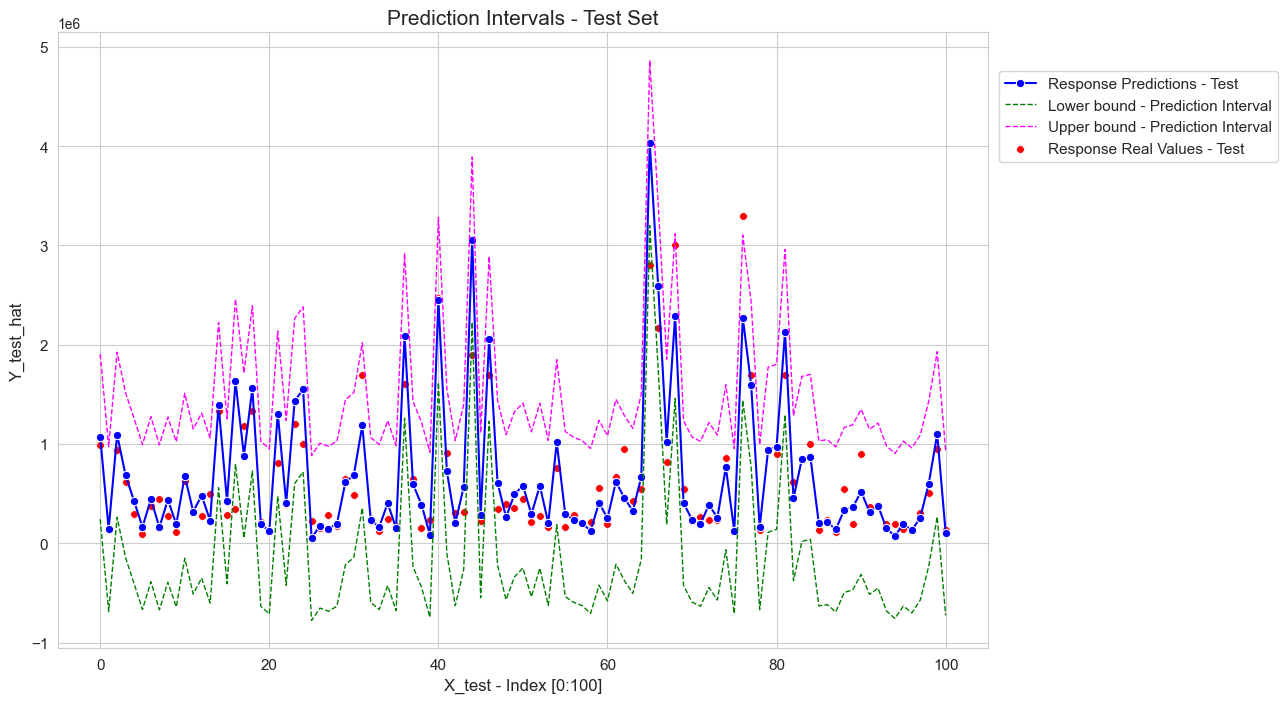

The percentage of real values of the response (all the red points) that are out of the prediction intervals is 3.99 %


In [166]:
prediction_intervals(X[predictors_selected['LRT_inter']], Y, 
                     pred_to_dummies=None, 
                     interactions_to_add=interactions_selected['LRT_inter'], 
                     alpha=0.05, train_size=0.70, seed=123, subset_len=100, figsize=(12,8))

### **Coefficient Interpretation: theory**

#### **Without interactions**

##### **Interpretation of quantitative predictors**

Suppose that $\mathcal{X}_j$ is a **quantitative** variable. 

We have the following estimation:


$$\widehat{y}_i = \widehat{\beta}_0 + \widehat{\beta}_{1}\cdot x_{i1} + \dots +  \widehat{\beta}_{j} \cdot x_{ij} + \dots +   \widehat{\beta}_{p}\cdot x_{ip}$$

- If $\mathcal{X}_j$ increases in $h>0$ units, in sample terms, the new value of the variable $X_j$ is $X_j + c$, and we can express this as $X'_j =X_j +c$, then:

   $$\widehat{y}_i | x_{ij}^\prime = x_{ij} + h \hspace{0.12cm}  - \hspace{0.12cm} \widehat{y}_i |  x_{ij}  \hspace{0.12cm}  = \hspace{0.12cm} h \cdot \widehat{\beta}_j$$

   **Interpretation:**

   - If $\widehat{\beta}_j > 0 \hspace{0.02cm}$, then:

      - $\widehat{y}_i\hspace{0.05cm}$ increases in $\hspace{0.05cm}h \cdot \widehat{\beta}_j\hspace{0.05cm}$ $y$-units  if $x_{ij}$ increases in $h>0$ units, for $\small{i=1,\dots,n}$.

   - If $\widehat{\beta}_j < 0 \hspace{0.2cm}$, then:

      - $\widehat{y}_i\hspace{0.05cm}$ decreases in $\hspace{0.05cm}h \cdot \widehat{\beta}_j\hspace{0.05cm}$ $y$-units  if $x_{ij}$ increases in $h>0$ units, for $\small{i=1,\dots,n}$.

   Observation: the reasoning is analogous if the predictor decreases rather than increases, but in the opposite sense.

##### **Interpretation of categorical predictors**

Suppose that $\mathcal{X}_j$ is a **categorical** variable with $g$ categories $(Range(\mathcal{X}_j) = \lbrace 0,1,\dots, g-1\rbrace)$. 

$\mathcal{X}_j$ enter in the model with $g-1$ dummy predictors. Considering $0$ as the reference category, these dummy predictors that enter in the model to represent $\mathcal{X}_j$ are the following:

$$X_{j1},X_{j2},\dots , X_{j(g-1)}$$

with their associated beta parameters:

$$\beta_{j1}, \beta_{j2}, \dots , \beta_{j(g-1)}$$

Where: 

$$x_{ijr} = \begin{cases}
             1, \quad x_{ij} = r \\
             0, \quad x_{ij} \neq r
             \end{cases}$$

Note that $x_{ijr} = 1$ is equivalent to $x_{ij} = r$, and $x_{ij}=0$ is equivalent to $x_{ijr}=0$ for all $\small{r=1,2, \dots, g-1}$.

The estimation  would be:

$$\widehat{y}_i = \widehat{\beta}_0 + \widehat{\beta}_{1}\cdot x_{i1} + \dots +  \widehat{\beta}_{j1} \cdot x_{i j1} + \widehat{\beta}_{j2} \cdot x_{i j2} + \dots + \widehat{\beta}_{j(g-1)} \cdot x_{i j(g-1)} + \dots +   \widehat{\beta}_{p}\cdot x_{ip}$$

- Comparison between category $r$ and $0$ (the reference category):

   $$\widehat{y}_i | x_{ijr}  = r \hspace{0.12cm}  - \hspace{0.12cm} \widehat{y}_i |  x_{ij} =0  \hspace{0.12cm}  = \hspace{0.12cm}  \widehat{\beta}_{jr}$$

   **Interpretation:**

   - If $\widehat{\beta}_{jr} > 0 \hspace{0.02cm}$, then:

      - $\widehat{y}_i\hspace{0.05cm}$ is $\hspace{0.05cm}\widehat{\beta}_{jr}\hspace{0.1cm}$ $y$-units greater if $x_{ij}=r$  than if $x_{ij}=0$, for $\small{i=1,\dots,n}$.

   - If $\widehat{\beta}_{jr} < 0 \hspace{0.02cm}$, then:

      - $\widehat{y}_i\hspace{0.05cm}$ is $\hspace{0.05cm}\widehat{\beta}_{jr}\hspace{0.1cm}$ $y$-units lower if $x_{ij}=r$  than if $x_{ij}=0$, for $\small{i=1,\dots,n}$.


- Comparison between category $r_1$ and $r_2$ (the reference category):

   $$\widehat{y}_i | x_{ijr}  = r_1 \hspace{0.12cm}  - \hspace{0.12cm} \widehat{y}_i |  x_{ij} = r_2  \hspace{0.12cm}  = \hspace{0.12cm}  \widehat{\beta}_{jr_1} - \widehat{\beta}_{jr_2}$$

    **Interpretation:**

    - If $\widehat{\beta}_{jr_1} -\widehat{\beta}_{jr_2} > 0 \hspace{0.02cm}$, then:

       - $\widehat{y}_i\hspace{0.05cm}$ is $\hspace{0.05cm}\widehat{\beta}_{jr_1} -\widehat{\beta}_{jr_2} \hspace{0.1cm}$ $y$-units greater if $x_{ij}=r_1$  thant if $x_{ij}=r_2$, for $\small{i=1,\dots,n}$.

    - If $\widehat{\beta}_{jr} < 0 \hspace{0.02cm}$, then:

       - $\widehat{y}_i\hspace{0.05cm}$ is $\hspace{0.05cm}\widehat{\beta}_{jr_1} -\widehat{\beta}_{jr_2} \hspace{0.1cm}$ $y$-units greater if $x_{ij}=r_1$  thant if $x_{ij}=r_2$, for $\small{i=1,\dots,n}$.


#### **With interactions**

Suppose that $X_{j}$ is quantitative and $X_h$ is categorical with $g$ categories $\lbrace 0, 1, \dots, g-1\rbrace$ and the reference category is $0$.

And also suppose that the model includes an interaction between $X_j$ and $X_h$, then:

$$\widehat{y}_i = \widehat{\beta}_0 + \dots + \widehat{\beta}_j\cdot x_{ij} 
+ \widehat{\beta}_{h1} \cdot x_{i h1} + \dots + \widehat{\beta}_{h(g-1)} \cdot x_{i h(g-1)} + \\[0.15cm]

+ \widehat{\beta}_{jh1}\cdot x_{ij}\cdot x_{ih1} + \dots +   \widehat{\beta}_{jh(g-1)}\cdot x_{ij}\cdot x_{ih(g-1)}$$

Where:

- $\widehat{\beta}_{jh}$ is the coefficient fot he interaction between $X_j$ and $X_h$.

- $\widehat{\beta}_{jhr}$ is the coefficient fot he interaction between $X_j$ and $X_{hr}$, i.e. the dummy variable for category $r$ of $X_h$, for $\small{r=1,2,\dots,g-1}.$



##### **Quantitative predictors:**

- If $\mathcal{X}_j$ increases in $w>0$ units, in sample terms, the new value of the variable $X_j$ is $X_j + w$, and we can express this as $X'_j =X_j +w$, then:


  $$\widehat{y}_i |x'_{ij} = x_{ij} + w \hspace{0.1cm} - \hspace{0.1cm} \widehat{y}_i |x_{ij} \hspace{0.1cm}=\hspace{0.1cm}  w\cdot \widehat{\beta}_j + w\cdot x_{ih1} \cdot \widehat{\beta}_{jh1}+ \dots + w\cdot x_{ih(g-1)} \cdot \widehat{\beta}_{jh(g-1)} \\[0.3cm]
   = w\cdot \left(\widehat{\beta}_j +  x_{ih1} \cdot \widehat{\beta}_{jh1}+ \dots +  x_{ih(g-1)} \cdot \widehat{\beta}_{jh(g-1)} \right) = \phi(\cdot)$$

    **Interpretation:**

    Now the interpretation not only depend on the coefficient of the variable, but also on the coefficients and value of the categorical predictor with which an interaction has been set. 

    For  an individual with $x_{ih} = r$, i.e. $x_{ihr}=1$, then $\phi(\cdot) = w\cdot (\widehat{\beta}_j + \widehat{\beta}_{jhr})$.

    - If $\widehat{\beta}_j + \widehat{\beta}_{jhr} > 0$, then:
    
        - $\widehat{y}_i\hspace{0.05cm}$ is $\hspace{0.05cm}w    (\widehat{\beta}_j + \widehat{\beta}_{jhr})\hspace{0.05cm}$ $y$-units higher if $x_{ij}$ increases in $w>0$ units, for $\small{i=1,\dots,n}$.

    - If $\widehat{\beta}_j + \widehat{\beta}_{jhr} < 0$ , then:
    
        - $\widehat{y}_i$ is $w(\widehat{\beta}_j + \widehat{\beta}_{jhr})\hspace{0.05cm}$ $y$-units lower if $x_{ij}$ increases in $w>0$ units, for $\small{i=1,\dots,n}$.

    Observation: the reasoning is analogous if the predictor decreases rather than increases, but in the opposite sense.

##### **Categorical predictors:**

- Comparison between category $r$ and $0$ (the reference category) in $X_h$:

    $$\widehat{y}_i |x_{ih}=r \hspace{0.1cm} - \hspace{0.1cm} \widehat{y}_i |x_{ih}=0 \hspace{0.1cm}=\hspace{0.1cm} \widehat{\beta}_{hr} +  x_{ij} \cdot \widehat{\beta}_{jhr}$$


    **Interpretation:**

    Now the interpretation not only depend on the coefficient of the variable, but also on the coefficients and value of the quantitative predictor with which an interaction has been set. 

    - If $\widehat{\beta}_{hr} +  x_{ij} \cdot \widehat{\beta}_{jhr} > 0$ , then:
    
        - $\widehat{y}_i\hspace{0.05cm}$ is $\hspace{0.05cm}\widehat{\beta}_{hr} +  x_{ij} \cdot \widehat{\beta}_{jhr}\hspace{0.05cm}$  $y$-units greater if $x_{ih}=r$ than if $x_{ih}=0$, for $\small{i=1,\dots,n}$.

    - If $\widehat{\beta}_{hr} +  x_{ij} \cdot \widehat{\beta}_{jhr} < 0$ $\hspace{0.15cm}$, is fulfilled that:
    
        - $\widehat{y}_i\hspace{0.05cm}$ is $\hspace{0.05cm}\widehat{\beta}_{hr} +  x_{ij} \cdot \widehat{\beta}_{jhr}\hspace{0.05cm}$ $y$-units lower if $x_{ih}=r$ than if $x_{ih}=0$, for $\small{i=1,\dots,n}$.


- Comparison between category $r_1$ and $r_2$ (the reference category) in $X_h$:

    $$\widehat{y}_i |x_{ih}=r_1 - \widehat{y}_i |x_{ih}=r_2 = (\widehat{\beta}_{hr_1}- \widehat{\beta}_{hr_2})+  x_{ij} \cdot (\widehat{\beta}_{jhr_1}-\widehat{\beta}_{jhr_2})$$
 

    **Interpretation:**

    Now the interpretation not only depend on the coefficient of the variable, but also on the coefficients and value of the quantitative predictor with which an interaction has been set. 

    - If $(\widehat{\beta}_{hr_1}- \widehat{\beta}_{hr_2})+  x_{ij} \cdot (\widehat{\beta}_{jhr_1}-\widehat{\beta}_{jhr_2}) > 0$  , then:
    
        - $\widehat{y}_i\hspace{0.05cm}$ is $\hspace{0.05cm}(\widehat{\beta}_{hr_1}- \widehat{\beta}_{hr_2})+  x_{ij} \cdot (\widehat{\beta}_{jhr_1}-\widehat{\beta}_{jhr_2})\hspace{0.05cm}$ $y$-units higher if $x_{ih}=r_1$ than if $x_{ih}=r_2$, for $\small{i=1,\dots,n}$.

    - If $(\widehat{\beta}_{hr_1}- \widehat{\beta}_{hr_2})+  x_{ij} \cdot (\widehat{\beta}_{jhr_1}-\widehat{\beta}_{jhr_2}) < 0$ , then:
    
        - $\widehat{y}_i\hspace{0.05cm}$ is $\hspace{0.05cm}(\widehat{\beta}_{hr_1}- \widehat{\beta}_{hr_2})+  x_{ij} \cdot (\widehat{\beta}_{jhr_1}-\widehat{\beta}_{jhr_2})\hspace{0.05cm}$ $y$-units lower if $x_{ih}=r_1$ than if $x_{ih}=r_2$, for $\small{i=1,\dots,n}$.


### **Coefficient Interpretation: application**

The best model for prediction may not be the best for interpretation. 

In order to make this section more complete, we will use a model with interactions and dummies.

In [167]:
predictors_interpretation = ['sq_mt_built', 'n_rooms', 'n_bathrooms', 'n_floors', 
                              'has_lift', 'is_exterior', 'energy_certificate', 'has_parking', 'house_type']

interactions_interpretation = [('n_bathrooms', 'is_exterior'), ('sq_mt_built', 'is_exterior'), ('sq_mt_built', 'has_lift')]

pred_to_dummies_interpretation = [x for x in cat_predictors if x in predictors_interpretation]

In [168]:
interpretation_model = linear_model(Y=Y_train, X=X_train[predictors_interpretation])
interpretation_model.fit(pred_to_dummies=pred_to_dummies_interpretation, 
                        interactions_to_add=interactions_interpretation)

In [169]:
print(interpretation_model.linear_fit.summary())

                                 OLS Regression Results                                
Dep. Variable:              buy_price   R-squared (uncentered):                   0.857
Model:                            OLS   Adj. R-squared (uncentered):              0.857
Method:                 Least Squares   F-statistic:                              4338.
Date:                Fri, 29 Dec 2023   Prob (F-statistic):                        0.00
Time:                        10:12:38   Log-Likelihood:                     -2.1723e+05
No. Observations:               15217   AIC:                                  4.345e+05
Df Residuals:                   15196   BIC:                                  4.347e+05
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

**Interpreting coefficient of `sq_mt_built`**

The model has a interaction between `sq_mt_built` $(X_j)$ , `is_exterior` $(X_h)$ and `has_lift` $(X_k)$:



$$\widehat{y}_i | x_{ij}^\prime = x_{ij} + w  \hspace{0.2cm} - \hspace{0.2cm} \widehat{y}_i | x_{ij} \hspace{0.2cm} = \hspace{0.2cm} w\cdot (\widehat{\beta}_j + x_{ih1}\cdot \widehat{\beta}_{jh1} + x_{ik1}\cdot \widehat{\beta}_{jk1}) \\[0.2cm] \hspace{5.3cm}   = \hspace{0.2cm} w\cdot (1891.6 + x_{ih1}\cdot 579.6 + x_{ik1}\cdot 3204)$$

Observation: `is_exterior` and `has_lift` are binaries $\lbrace 0, 1\rbrace$.


- If the number of sq meters built of a house increases in $w=50 m^2$, then:

    - If the house is exterior $(x_{ih1}=1)$ and has lift $(x_{ik1}=1)$, then its price increases in 284066.5 €

    - If the house is not exterior $(x_{ih1}=0)$ but has lift $(x_{ik1}=1)$, then  its price increases in 243765 €

    - If the house is exterior $(x_{ih1}=1)$ but doesn't have lift $(x_{ik1}=0)$, then its price increases in 123524 €

    - If the house is not exterior $(x_{ih1}=0)$ and doesn't have lift $(x_{ik1}=0)$, then its price increases in 83222.5 €

Summarizing:

When the `sq_mt_built` of a house increases, the estimated price increases, but the intensity (quantity) of this increases depend on wether the house is exterior or not and wether has lift or not, because we have establish an interaction between these predictors.

We can make an intensity ranking, from more to less intensity, depending on the values of `is_exterior` $(x_{ih1})$ and `has_lift` $(x_{ik1})$:

$$x_{ih1} = x_{ik1} = 1$$
$$x_{ih1} = 0 \hspace{0.1cm};\hspace{0.1cm}  x_{ik1} = 1$$
$$x_{ih1} =1 \hspace{0.1cm};\hspace{0.1cm}  x_{ik1} = 0$$
$$x_{ih1} = x_{ik1} = 0$$

**Interpreting coefficient of `n_bathrooms`**

The model has a interaction between `n_bathrooms` $(X_j)$ and `is_exterior` $(X_h)$:



$$\widehat{y}_i | x_{ij}^\prime = x_{ij} + w  \hspace{0.2cm} - \hspace{0.2cm} \widehat{y}_i | x_{ij} \hspace{0.2cm} = \hspace{0.2cm} w\cdot (\widehat{\beta}_j + x_{ih1}\cdot \widehat{\beta}_{jh1} ) \\[0.2cm] \hspace{5.3cm}   = \hspace{0.2cm} w\cdot (148600 - x_{ih1}\cdot 34590 )$$

Observation: `is_exterior` is binary $\lbrace 0, 1\rbrace$.


- If the number of bathrooms of a house increases in $w=1$ bathroom, then:

    - If the house is exterior $(x_{ih1}=1)$, its price increases in 114010 €

    - If the house is not exterior $(x_{ih1}=0)$, its price increases in 148600 €


In conclusion:

When the `n_bathrooms` of a house increases, the estimated price increases as well, but the intensity (quantity) of this increases depend on wether the house is exterior or not, because we have establish an interaction between these predictors.

If the house is exterior $(x_{ih1}=1)$, the intensity of the increases is lower than if is not exterior $(x_{ih1}=0)$.


**Interpreting coefficient of `n_rooms`**

Let suppose that `n_rooms` is $X_j$:


$$\widehat{y}_i | x_{ij}^\prime = x_{ij} + w  \hspace{0.2cm} - \hspace{0.2cm} \widehat{y}_i | x_{ij} \hspace{0.2cm} = \hspace{0.2cm} w\cdot \widehat{\beta}_j  \hspace{0.2cm}  \\[0.2cm] \hspace{4.9 cm}   = \hspace{0.2cm}   -w\cdot 42140$$




- If the number of rooms increases in $w=1$ room, the house price decreases in 42140 €




**Interpreting coefficient of `n_floors`**

Let suppose that `n_floors` is $X_j$:


$$\widehat{y}_i | x_{ij}^\prime = x_{ij} + w  \hspace{0.2cm} - \hspace{0.2cm} \widehat{y}_i | x_{ij} \hspace{0.2cm} = \hspace{0.2cm} w\cdot \widehat{\beta}_j  \hspace{0.2cm}  \\[0.2cm] \hspace{4.9 cm}   = \hspace{0.2cm}   w\cdot 7617.84$$




- If the number of floors increases in $w=1$ floor, the house price increases in 7617.84 €


**Interpreting coefficient of `has_lift`**

The model has a interaction between `has_lift` $(X_h)$ and `sq_mt_built` $(X_j)$:

$$\widehat{y}_i | x_{ih} = 1  \hspace{0.2cm} - \hspace{0.2cm} \widehat{y}_i | x_{ih} = 0\hspace{0.2cm} = \hspace{0.2cm}  \widehat{\beta}_{h1} + x_{ij}\cdot \widehat{\beta}_{jh1} ) \\[0.2cm] \hspace{5.3cm}   = \hspace{0.2cm} -187500 + x_{ij}\cdot 1891.6$$

Observation: `has_lift` is binary $\lbrace 0, 1\rbrace$.

- For houses with 150 sq meters built, their price is 96150€ greater if they have lift than if not.

- For house with 90 sq meter built, their price is 17256 € lower if they have lift than if not.

In conclusion:

- For big houses, tho have a lift increases the price.

- For small houses, tho have a lift decreases the price.



**Interpreting coefficient of `is_exterior`**

The model has a interaction between `is_exterior` $(X_h)$, `n_bathrooms` $(X_j)$ and `sq_mt_built` $(X_k)$:



$$\widehat{y}_i | x_{ih}=1   \hspace{0.2cm} - \hspace{0.2cm} \widehat{y}_i | x_{ih}=0 \hspace{0.2cm} = \hspace{0.2cm}\widehat{\beta}_{h1} + x_{ij}\cdot \widehat{\beta}_{jh1} + x_{ik}\cdot \widehat{\beta}_{kh1}) \\[0.2cm] \hspace{5.1cm}   = \hspace{0.2cm} -29740-x_{ij}\cdot 34590 + x_{ik}\cdot 579.6$$

Observation: `is_exterior` is binary $(0,1)$.

- For houses with 2 bathrooms and 100 sq meters built, their price is 40960 € lower if are exterior.

- For houses with 2 bathrooms and 200 sq meters built, their price is 17000 € greater if are exterior.

- For houses with 3 bathrooms and 200 sq meters built, their price is 17590 € lower if are exterior.

In conclusion:

- Houses with few enough bathrooms and large enough sq meters built are more expensive if are exterior.

- Houses with not few enough bathrooms or not large enough sq meters built are more expensive if are not exterior.



**Interpreting coefficient of `energy_certificate`**

`energy_certificate` $(X_h)$ is multiclass with 8 categories $\lbrace 0,1,\dots , 7\rbrace$.

$$\widehat{y}_i | x_{ih}=7   \hspace{0.2cm} - \hspace{0.2cm} \widehat{y}_i | x_{ih}=0 \hspace{0.2cm} = \hspace{0.2cm} \widehat{\beta}_{h7} = 61810$$

$$\widehat{y}_i | x_{ih}=7   \hspace{0.2cm} - \hspace{0.2cm} \widehat{y}_i | x_{ih}=6 \hspace{0.2cm} = \hspace{0.2cm} \widehat{\beta}_{h7} - \widehat{\beta}_{h6}  = 16010$$

- Price of houses with energy certificate 7 is 61810€ greater than the one of houses with certificate 0.

- Price of houses with energy certificate 7 is 16010 € greater than the one of houses with certificate 6.

**Interpreting coefficient of `has_parking`**

`has_parking` $(X_h)$ is binary $\lbrace 0, 1\rbrace$

$$\widehat{y}_i | x_{ih}=1   \hspace{0.2cm} - \hspace{0.2cm} \widehat{y}_i | x_{ih}=0 \hspace{0.2cm} = \hspace{0.2cm} \widehat{\beta}_{h1} = -67590$$


- Price of houses with parking is 67590 € lower than the one of houses with without.
 

**Interpreting coefficient of `house_type`**

`house_type` $(X_h)$ is multiclass with 4 categories $\lbrace 0,1,2,3\rbrace$.

$$\widehat{y}_i | x_{ih}=1   \hspace{0.2cm} - \hspace{0.2cm} \widehat{y}_i | x_{ih}=0 \hspace{0.2cm} = \hspace{0.2cm} \widehat{\beta}_{h1} = 294100$$

$$\widehat{y}_i | x_{ih}=1   \hspace{0.2cm} - \hspace{0.2cm} \widehat{y}_i | x_{ih}=4 \hspace{0.2cm} = \hspace{0.2cm} \widehat{\beta}_{h1} - \widehat{\beta}_{h4}  = 246630$$

- Price of houses of type 1 (chalets)   is 294100€ greater than the one of houses type 0 (flats).

- Price of houses of type 1 (chalets)   is 246630 € greater than the one of houses type 4 (top floor).


### **Model Problems**

#### **Violation of model assumptions**

In this section we will check if the basic model assumptions are fulfilled.

First, since the assumptions are related with the residuals, we estimate them, for the best model.

In [170]:
Y_train_hat = best_model.predict(X_train[predictors_selected['LRT_inter']])
residuals_est =  Y_train - Y_train_hat

##### **Violation of null mean of the residuals**

To check the null mean assumption we can perform a t-test on the  residuals along with a plot like the next one (although in this case in not very informative due to the big scale of the response variable).

Residuals mean = 558.8809228895557


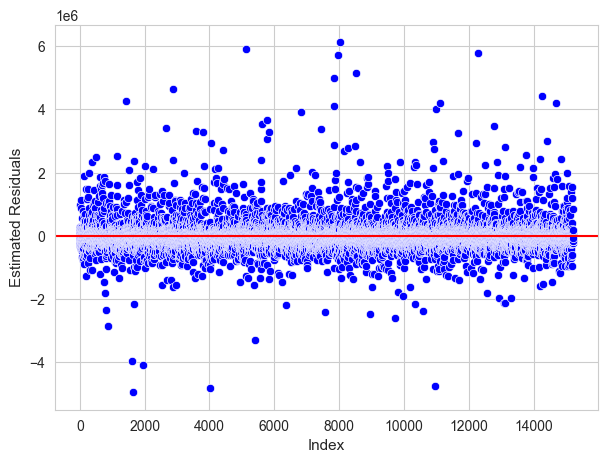

In [187]:
plt.subplots(figsize=(7,5))
ax = sns.scatterplot(y=residuals_est, x=np.arange(0,len(residuals_est)), color='blue')
plt.axhline(y=np.mean(residuals_est), color='r', linestyle='-')
ax.set_ylabel('Estimated Residuals', size=11)
ax.set_xlabel('Index', size=11)
print(f'Residuals mean = {np.mean(residuals_est)}')
plt.show()

We compute the pvalue of the t-test for the null mean of the residuals.

In [172]:
t_statistic, p_value = stats.ttest_1samp(residuals_est, 0)

In [173]:
p_value

0.8583305763037111

For the typical significance level $(\alpha = 0.05)$, we cannot reject that $E[\varepsilon_i]=0$. Therefore, the null mean of the residuals assumption is not fulfilled.

#### **Violation of constant variance of the residuals**

It is not possible to check the constant variance assumption just  by analyzing the residuals, because some of them will be high and others low, but this doesn't prove anything.

It is necessary to check if the residual variance is related to any other quantity, so that for certain values of that quantity the residual variance is bigger than for others, and, therefore confirming that it is not constant.

The most useful diagnosis is the scatter plot for $\widehat{\varepsilon}$ vs $\widehat{Y}$.

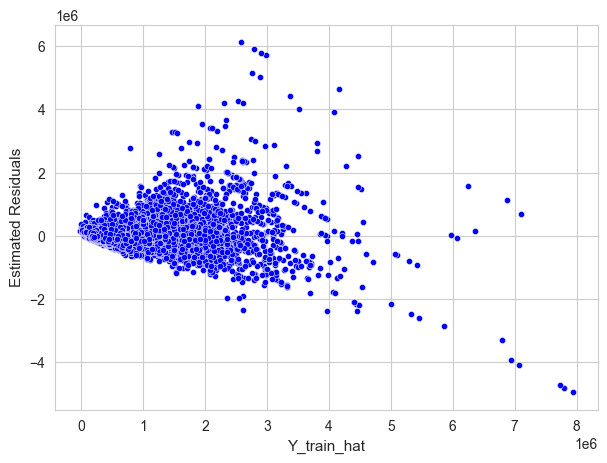

In [185]:
plt.subplots(figsize=(7,5))
ax = sns.scatterplot(x=Y_train_hat, y=residuals_est, marker='o', color='blue', s=20) 
ax.set_ylabel('Estimated Residuals', size=11)
ax.set_xlabel('Y_train_hat', size=11)
plt.show() 

#### **Violation of Normality of the residuals**

To check the normality of the residuals we will compare their histogram with the one they would have if would be perfectly normal distributed.

In [175]:
normal_residuals = np.random.normal(np.mean(residuals_est), np.std(residuals_est), len(residuals_est))

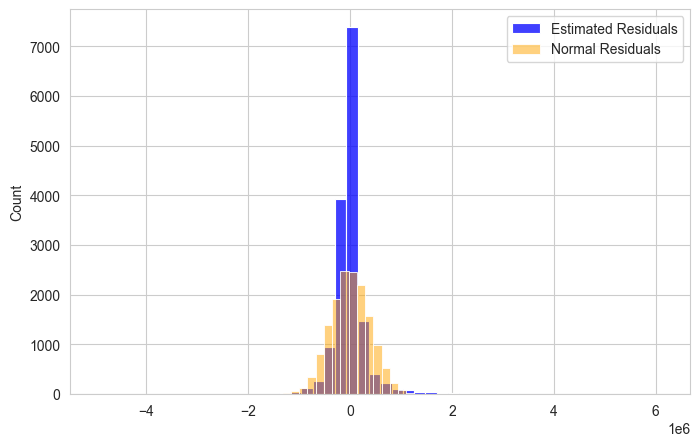

In [176]:
plt.figure(figsize=(8, 5))
sns.histplot(residuals_est, bins=50, color='blue', label='Estimated Residuals')
sns.histplot(normal_residuals, bins=20, color='orange', label='Normal Residuals', alpha=0.5)
plt.legend() 
plt.show()

We can also use a qq-plot to test normality graphically.

<Figure size 800x600 with 0 Axes>

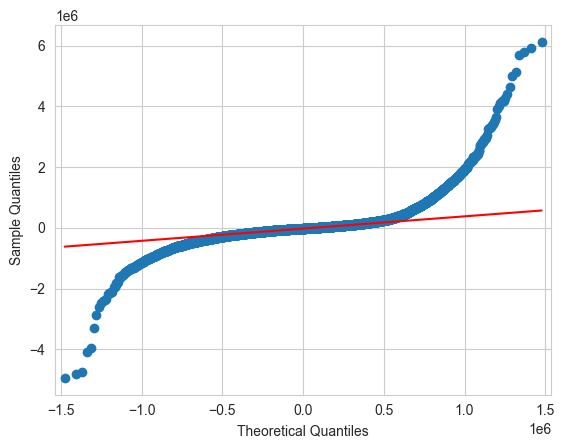

In [184]:
plt.figure(figsize=(8, 6))
ax = sm.qqplot(residuals_est, line ='q', loc=residuals_est.mean(), scale=residuals_est.std()) 
plt.show() 

In this case hypothesis test are not useful due to the number of observation involved in our data. So, our analysis can only be based on this kind of visual tools, which is imprecise.

#### **Violation of null auto-correlation of the residuals**



The residuals null correlation assumption can be check by mean of the Durban-Watson test.

The Durban-Watson test hypothesis are the following: 

$$H_0: \hspace{0.05cm} Corr\left(\varepsilon_{i}\hspace{0.05cm},\hspace{0.05cm} \varepsilon_{i+1}\right) = 0 \hspace{0.05cm} ,\hspace{0.13cm} \forall \hspace{0.1cm}i =1,...,n-1$$ 

$$H_1: \hspace{0.05cm}  Corr\left(\varepsilon_{i}\hspace{0.05cm},\hspace{0.05cm} \varepsilon_{i+1}\right) \neq 0 \hspace{0.05cm} ,\hspace{0.13cm} \exists \hspace{0.1cm}i =1,...,n-1 \\[0.5cm]$$



**Statistic Test:**

$$
DW \hspace{0.05cm}=\hspace{0.05cm} \dfrac{\sum_{i=1}^{n-1} (\hat{\varepsilon}_i - \hat{\varepsilon}_{i+1})^2 }{\sum_{i=1}^{n} \hat{\varepsilon}_{i}^2 }
$$



**Interpretation:**

The following is fulfilled:

$$
DW \hspace{0.1cm}\simeq \hspace{0.1cm} 2\cdot (1- r_{12})
$$

where:

$r_{12}\hspace{0.02cm}$  is the linear correlation between  $\hspace{0.02cm}\hat{\varepsilon}_{(1)} = (\hat{\varepsilon}_1 , \hat{\varepsilon}_2 ,..., \hat{\varepsilon}_{n-1})\hspace{0.05cm}$ and $\hspace{0.05cm}\hat{\varepsilon}_{(2)} = (\hat{\varepsilon}_2  ,...,\hat{\varepsilon}_{n-1}, \hat{\varepsilon}_{n})$


- The statistic test is between $0$ and $4$, because $r_{12}$ is between $-1$ and $1$.

-  An statistic of $DW=2$ indicates evidence of that residuals are not autocorrelate, so,  evidence in favor of $H_0$. 

-  An statistic of $DW$ close to $0$ indicates evidence of that residuals are positively autocorrelate, so,  evidence in favor of $H_1$. 

-  An statistic of $DW$ close to $4$ indicates evidence of that residuals are negatively autocorrelate, so,  evidence in favor of $H_1$. 
 


In [178]:
residuals_est = residuals_est.to_numpy()
residuals_est_0 = residuals_est[0:len(residuals_est)-1]
residuals_est_1 = residuals_est[1:len(residuals_est)]

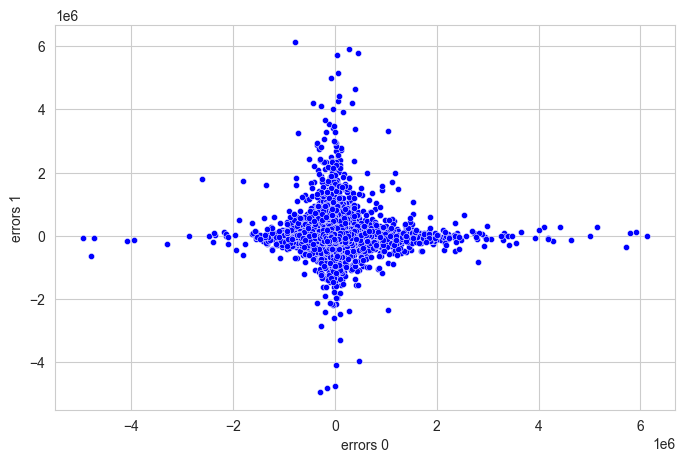

In [179]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=residuals_est_0, y=residuals_est_1, color='blue',marker='o', s=20)
plt.xlabel('errors 0')
plt.ylabel('errors 1')
plt.show()

In [180]:
np.corrcoef(residuals_est_0, residuals_est_1)[0,1]

-0.006553447280479784

In [181]:
sm.stats.stattools.durbin_watson(residuals_est, axis=0)

2.012363440433914

The Durban Watson statistic is close to $2$, what indicate evidence of no auto-correlation of the residuals.

#### **Multicollinearity**


The multicollinearity problem occurs when some of the predictors are linearly dependent.
 

**Why is multicollinearity a problem?**

-  In the worst of the cases, the existence of multicollinearity makes impossible the estimation of the model

- In the best of cases, the existence of multicollinearity makes the estimators of the beta coefficients very imprecise, therefore, with high variance. This implies that some significant predictors could be accepted as not significant, because the results of the significance test are affected by the variance of those estimators. The larger the variance of an estimator of the beta coefficient is, the smaller the statistical test of significance will be, and this makes it easier not  rejecting the null hypothesis that the predictor is not significant.

 



##### **Perfect Multicollinearity**

At least one of the predictors is a linear combination of the rest, so, 
$\hspace{0.02cm}Rg(X) \hspace{0.03cm}<\hspace{0.03cm} p+1 \hspace{0.02cm}$, in other words,  the $\mathbf{X}$ matrix hasn't complete range.

Because of the theorem of range-nullity we have te following:

$$Rg\left({X}^\prime \cdot {X}\right) \hspace{0.03cm}<\hspace{0.03cm} p+1$$

Therefore,  $\hspace{0.01cm}\mathbf{X}^\prime \cdot {X}\hspace{0.02cm}$ hasn't complete range, so $\hspace{0.02cm}\left({X}^\prime\cdot {X}\right)^{-1}\hspace{0.02cm}$ doesn't exist. As a consequence of the last, $\hspace{0.02cm}(\beta_0,{\beta})\hspace{0.02cm}$ cannot be estimated with ordinary least squares method (OLS).





##### **High Multicollinearity**

There are pairs of predictors with high linear correlation among them.

But, even in this case, the estimation of the beta coefficients is still possible, but the variance of the estimators will be very high, so, the estimations will be very imprecise and significant predictors could  be shown as not significant by mean of the significance test.



##### **Multicollinearity Identification**  

Multicollinearity identification can be carry out following different ways.

- If the linear regression model has only **quantitative** predictors: 

    - With the Pearson correlation matrix of the predictors.

    - With the Variance Increment Factor  $VIF$ .  

    -  With the conditioning number of  the correlation matrix.


- If the linear regression model has both **quantitative** and **categorical** predictors:

    -  With the Generalized Variance Increment Factor   $GVIF$.


In this project we will not go beyond the first option, in order not to make the project even more extensive.


##### **Multicollinearity identification with the linear correlation matrix**  

Assuming that $\hspace{0.02cm}X=(X_1 ,..., X_p)\hspace{0.02cm}$  is a quantitative data matrix.

The linear correlation matrix of $\hspace{0.02cm}X\hspace{0.02cm}$ is define as follows:

$$
\\[0.5cm]
R_{X}= \begin{pmatrix}
    r_{11} & r_{12}&...&r_{1p}\\
    r_{21} & r_{22}&...&r_{2p}\\
    ...&...&...&...\\
    r_{p1}& r_{p2}&...&r_{pp}
\end{pmatrix} = [r_{jh} ]_{\hspace{0.04cm} j,h \hspace{0.02cm} = \hspace{0.02cm}  1,..,p}
$$ 



where: 

$$
r_{j h} = \frac{s_{jh}}{\hspace{0.07cm} s_j \cdot s_h\hspace{0.07cm} } 
$$

is the linear correlation coefficient between $X_j$ and $X_h$, being $\hspace{0.02cm} s_j = \sigma^2(X_j) \hspace{0.02cm} and $s_{jh}$  the covariance  between $X_j$ and $X_h$, i.e:
$$
s_{jh} \hspace{0.05cm}=\hspace{0.05cm} \frac{\hspace{0.1cm} 1\hspace{0.1cm} }{n} \cdot \sum_{i=1}^{n} \left(\hspace{0.05cm} x_{ij} - \overline{X}_j \hspace{0.05cm}\right)\cdot \left(\hspace{0.05cm} x_{ih} - \overline{X}_h \hspace{0.05cm}\right)
$$


**Criteria:**


We have a estimated linear regression model $\widehat{Y}=\beta_0 + X\cdot \widehat{\beta} \hspace{0.04cm}$  only with quantitative predictors. 


- If there are any high correlation, namely, $\hspace{0.02cm} | r_{ih} |\hspace{0.02cm} > \hspace{0.02cm} 0.75 \hspace{0.07cm}$  $\Rightarrow\hspace{0.07cm}$ **multicollinearity problems**.



In [182]:
corr_matrix_ = corr_matrix(df=X_Y_train_df, quant_col_names=quant_columns, method='pearson')

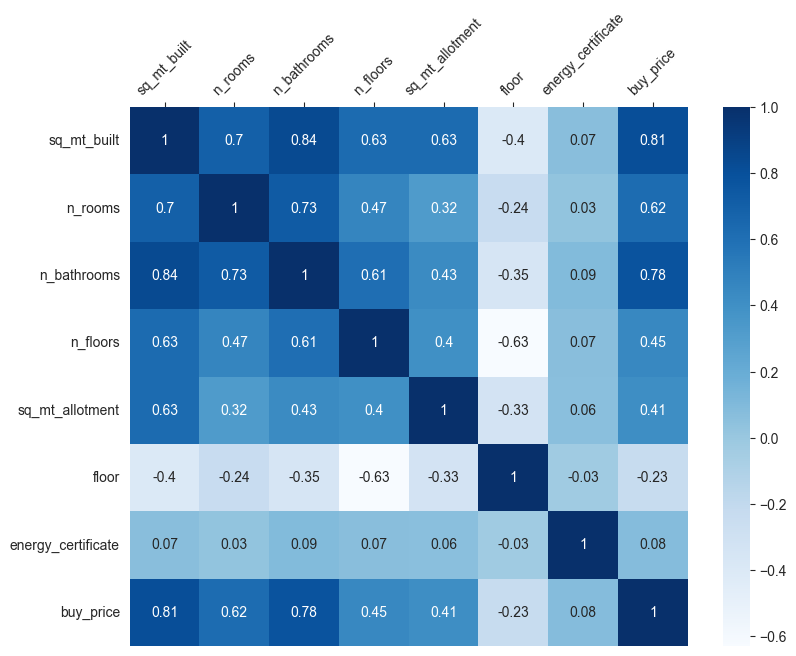

In [183]:
fig = plt.subplots(figsize=(9,7))
ax = sns.heatmap(corr_matrix_, cmap="Blues", annot=True)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.show()

As we can see there are quantitative predictors with high correlation, such as (`sq_mt_built`, `n_bathrooms`). So that, a model that include these predictors may have multicolinearity problems, leading to imprecise estimation of the beta coefficients.